In [57]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
#vutils
import torchvision.utils as vutils
import gc

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [58]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

    def sample(self, num_samples):
        """
        Generate new data by sampling random variables and decoding them to the data space.
        
        Args:
            num_samples (int): the number of samples to generate.

        Returns:
            torch.Tensor: a tensor of generated data.
        """
        z = torch.randn(num_samples, self.fc31.out_features).to(self.fc1.weight.device)
        return self.decoder(z)

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [59]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [60]:
optimizer = optim.Adam(vae.parameters())
sigma = 0.0


from fastDP import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier

learning_rate = 0.001
batch_size = bs
epochs = 9
target_epsilon = 1.
dp = True
if dp:
    sigma=get_noise_multiplier(
                    target_epsilon = target_epsilon,
                    target_delta = 1e-6,
                    sample_rate = batch_size/len(train_dataset),
                    epochs = epochs,
                )

    # privacy_engine = PrivacyEngine(
    #     model,
    #     batch_size=batch_size,
    #     sample_size=len(train_dataset),
    #     epochs=epochs,
    #     target_epsilon=100.,
    #     clipping_fn='automatic',
    #     clipping_mode='MixOpt',
    #     origin_params=None,
    #     clipping_style='all-layer',
    # )

    privacy_engine = PrivacyEngine(
                vae,
                batch_size=batch_size,
                sample_size=len(train_dataset),
                noise_multiplier=sigma,
                epochs=epochs,
                clipping_mode='MixOpt',
                origin_params=None,
            )
    privacy_engine.attach(optimizer)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

Number of trainable components:  14 ; Number of trainable layers:  7
>>>>>>>>>>>>>>>>> Applying  automatic  per-sample gradient clipping.
>>>>>>>>>>>>>>>>> Block heads for per-sample gradient clipping are defined as: ['fc1']


In [61]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [62]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 0 [0/60000 (0%)]	Loss: 546.416367
Train Epoch: 0 [10000/60000 (17%)]	Loss: 226.417227
Train Epoch: 0 [20000/60000 (33%)]	Loss: 221.782773
Train Epoch: 0 [30000/60000 (50%)]	Loss: 211.653340
Train Epoch: 0 [40000/60000 (67%)]	Loss: 209.835508
Train Epoch: 0 [50000/60000 (83%)]	Loss: 210.397383
====> Epoch: 0 Average loss: 234.0169
====> Test set loss: 204.0736


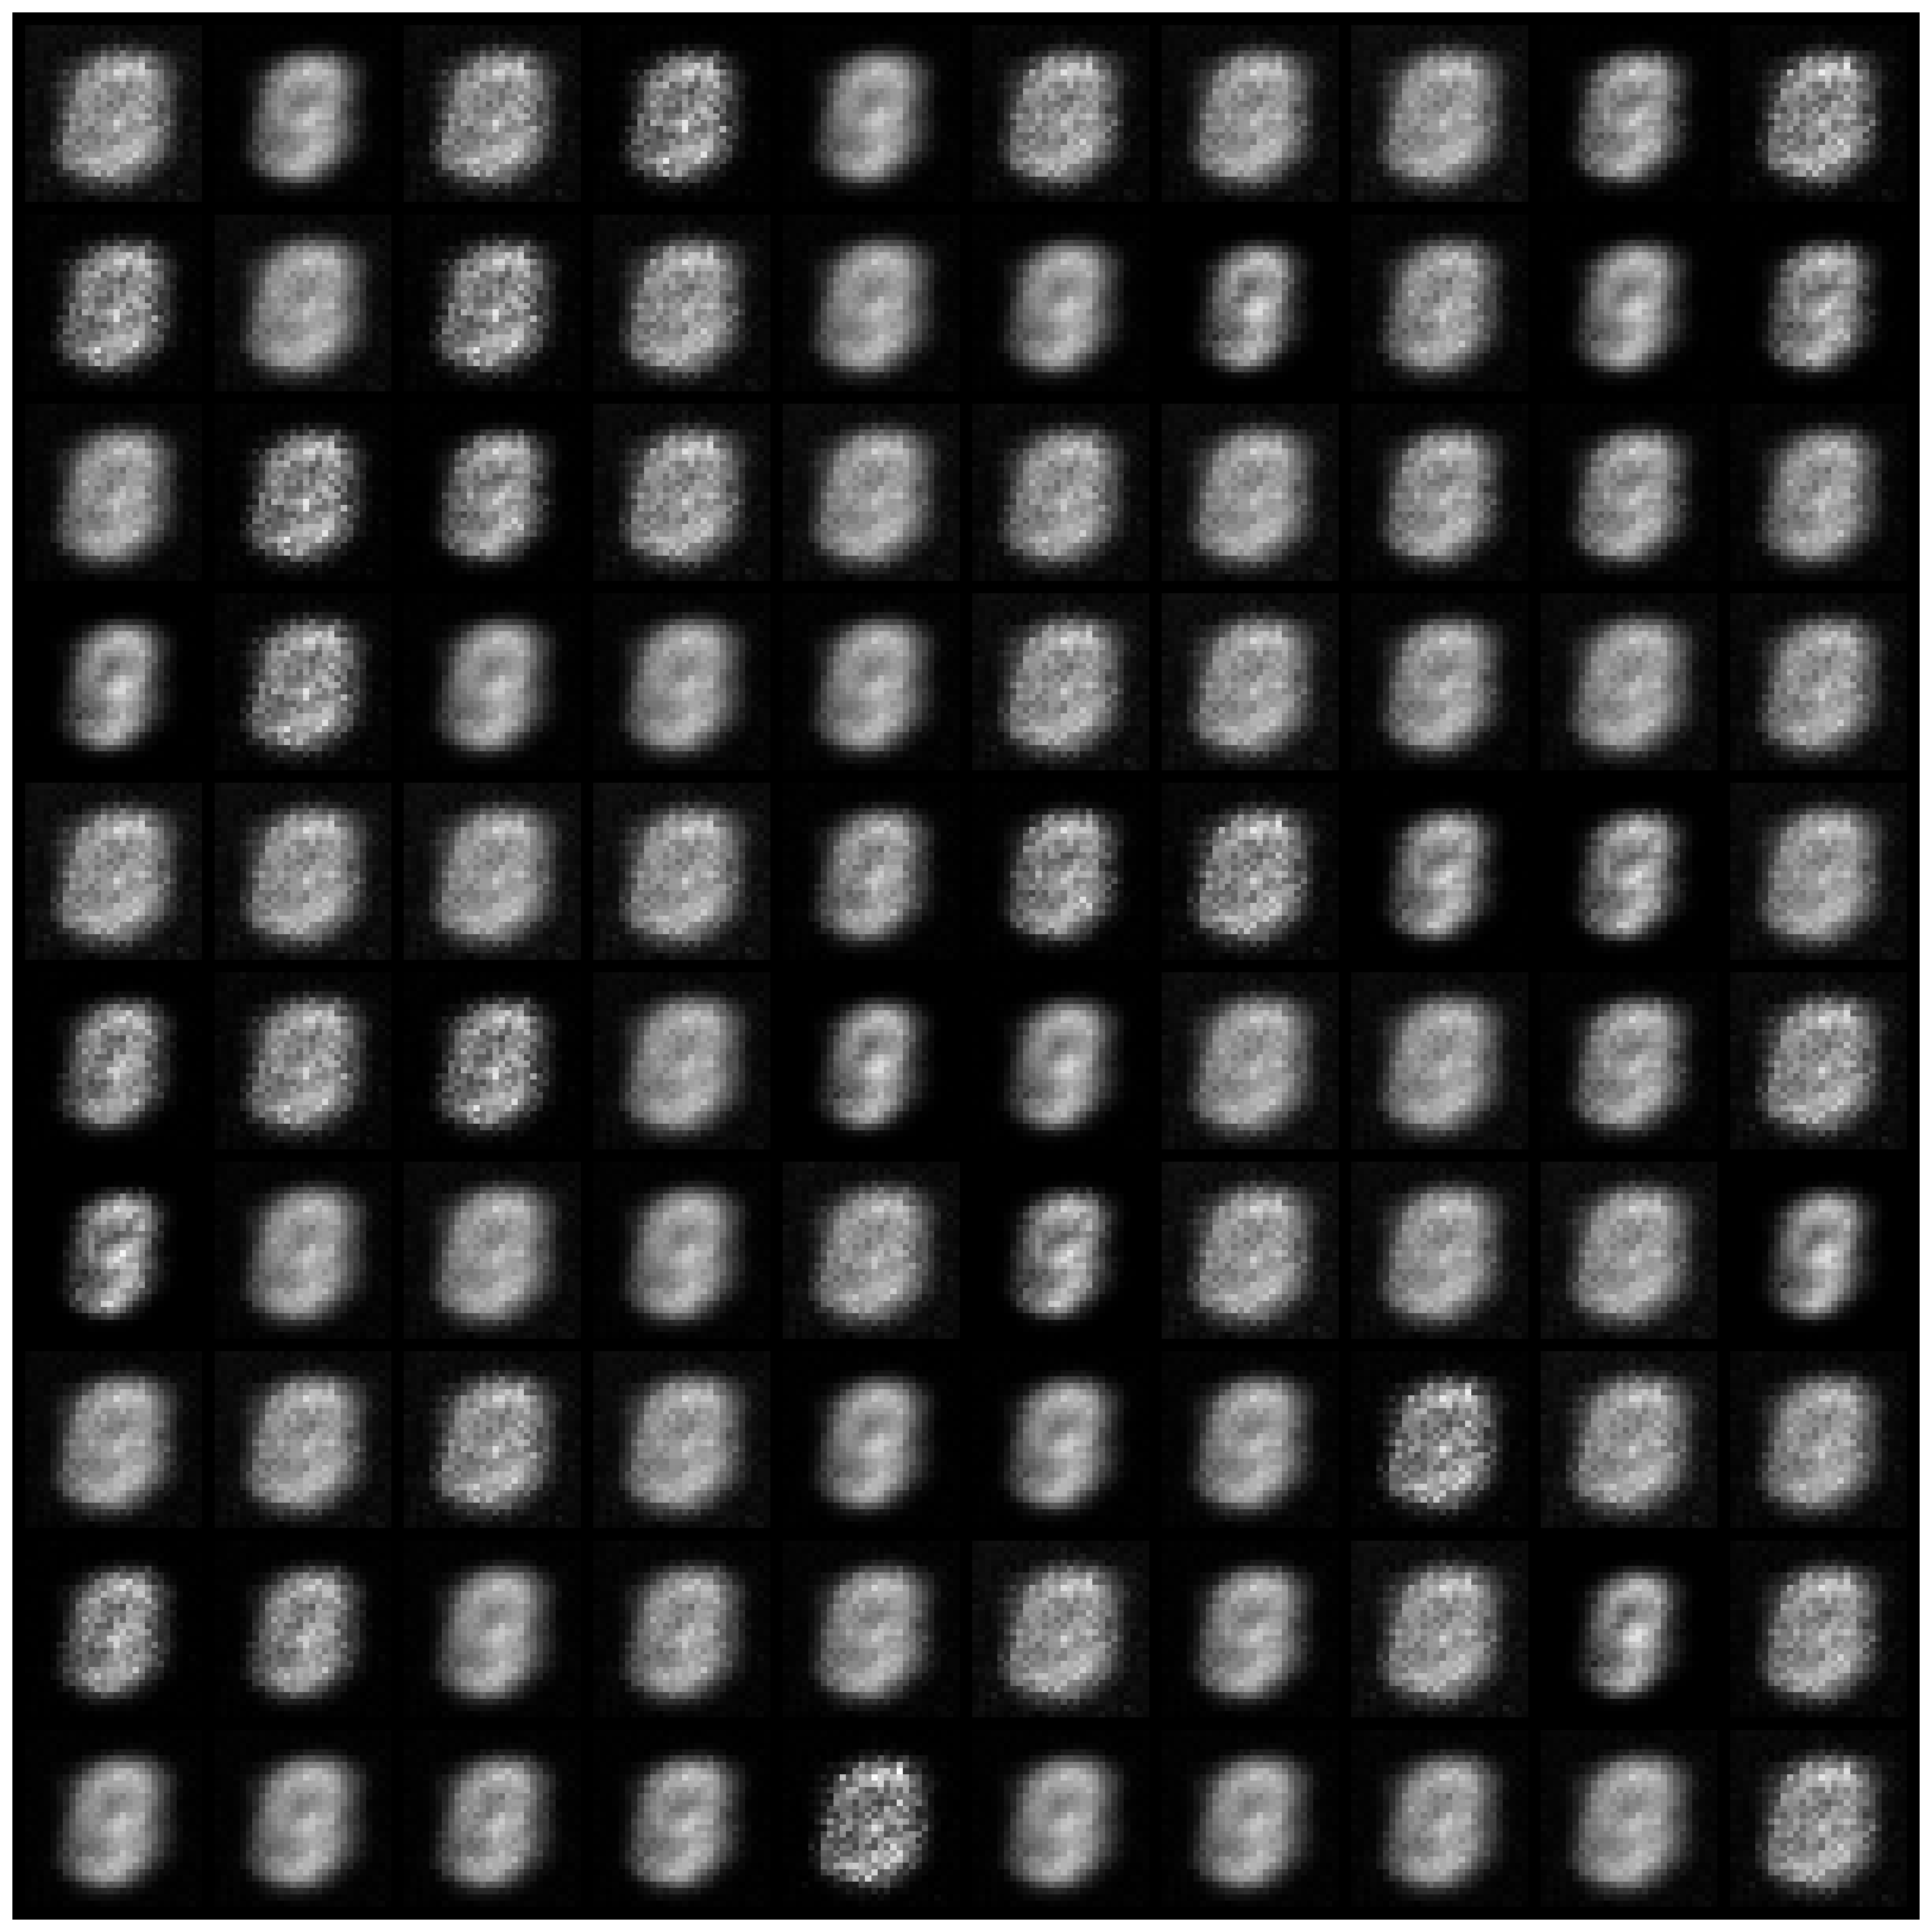

Train Epoch: 1 [0/60000 (0%)]	Loss: 206.835410
Train Epoch: 1 [10000/60000 (17%)]	Loss: 203.956094
Train Epoch: 1 [20000/60000 (33%)]	Loss: 196.131289
Train Epoch: 1 [30000/60000 (50%)]	Loss: 192.727461
Train Epoch: 1 [40000/60000 (67%)]	Loss: 199.561777
Train Epoch: 1 [50000/60000 (83%)]	Loss: 195.617617
====> Epoch: 1 Average loss: 199.5116
====> Test set loss: 195.8690


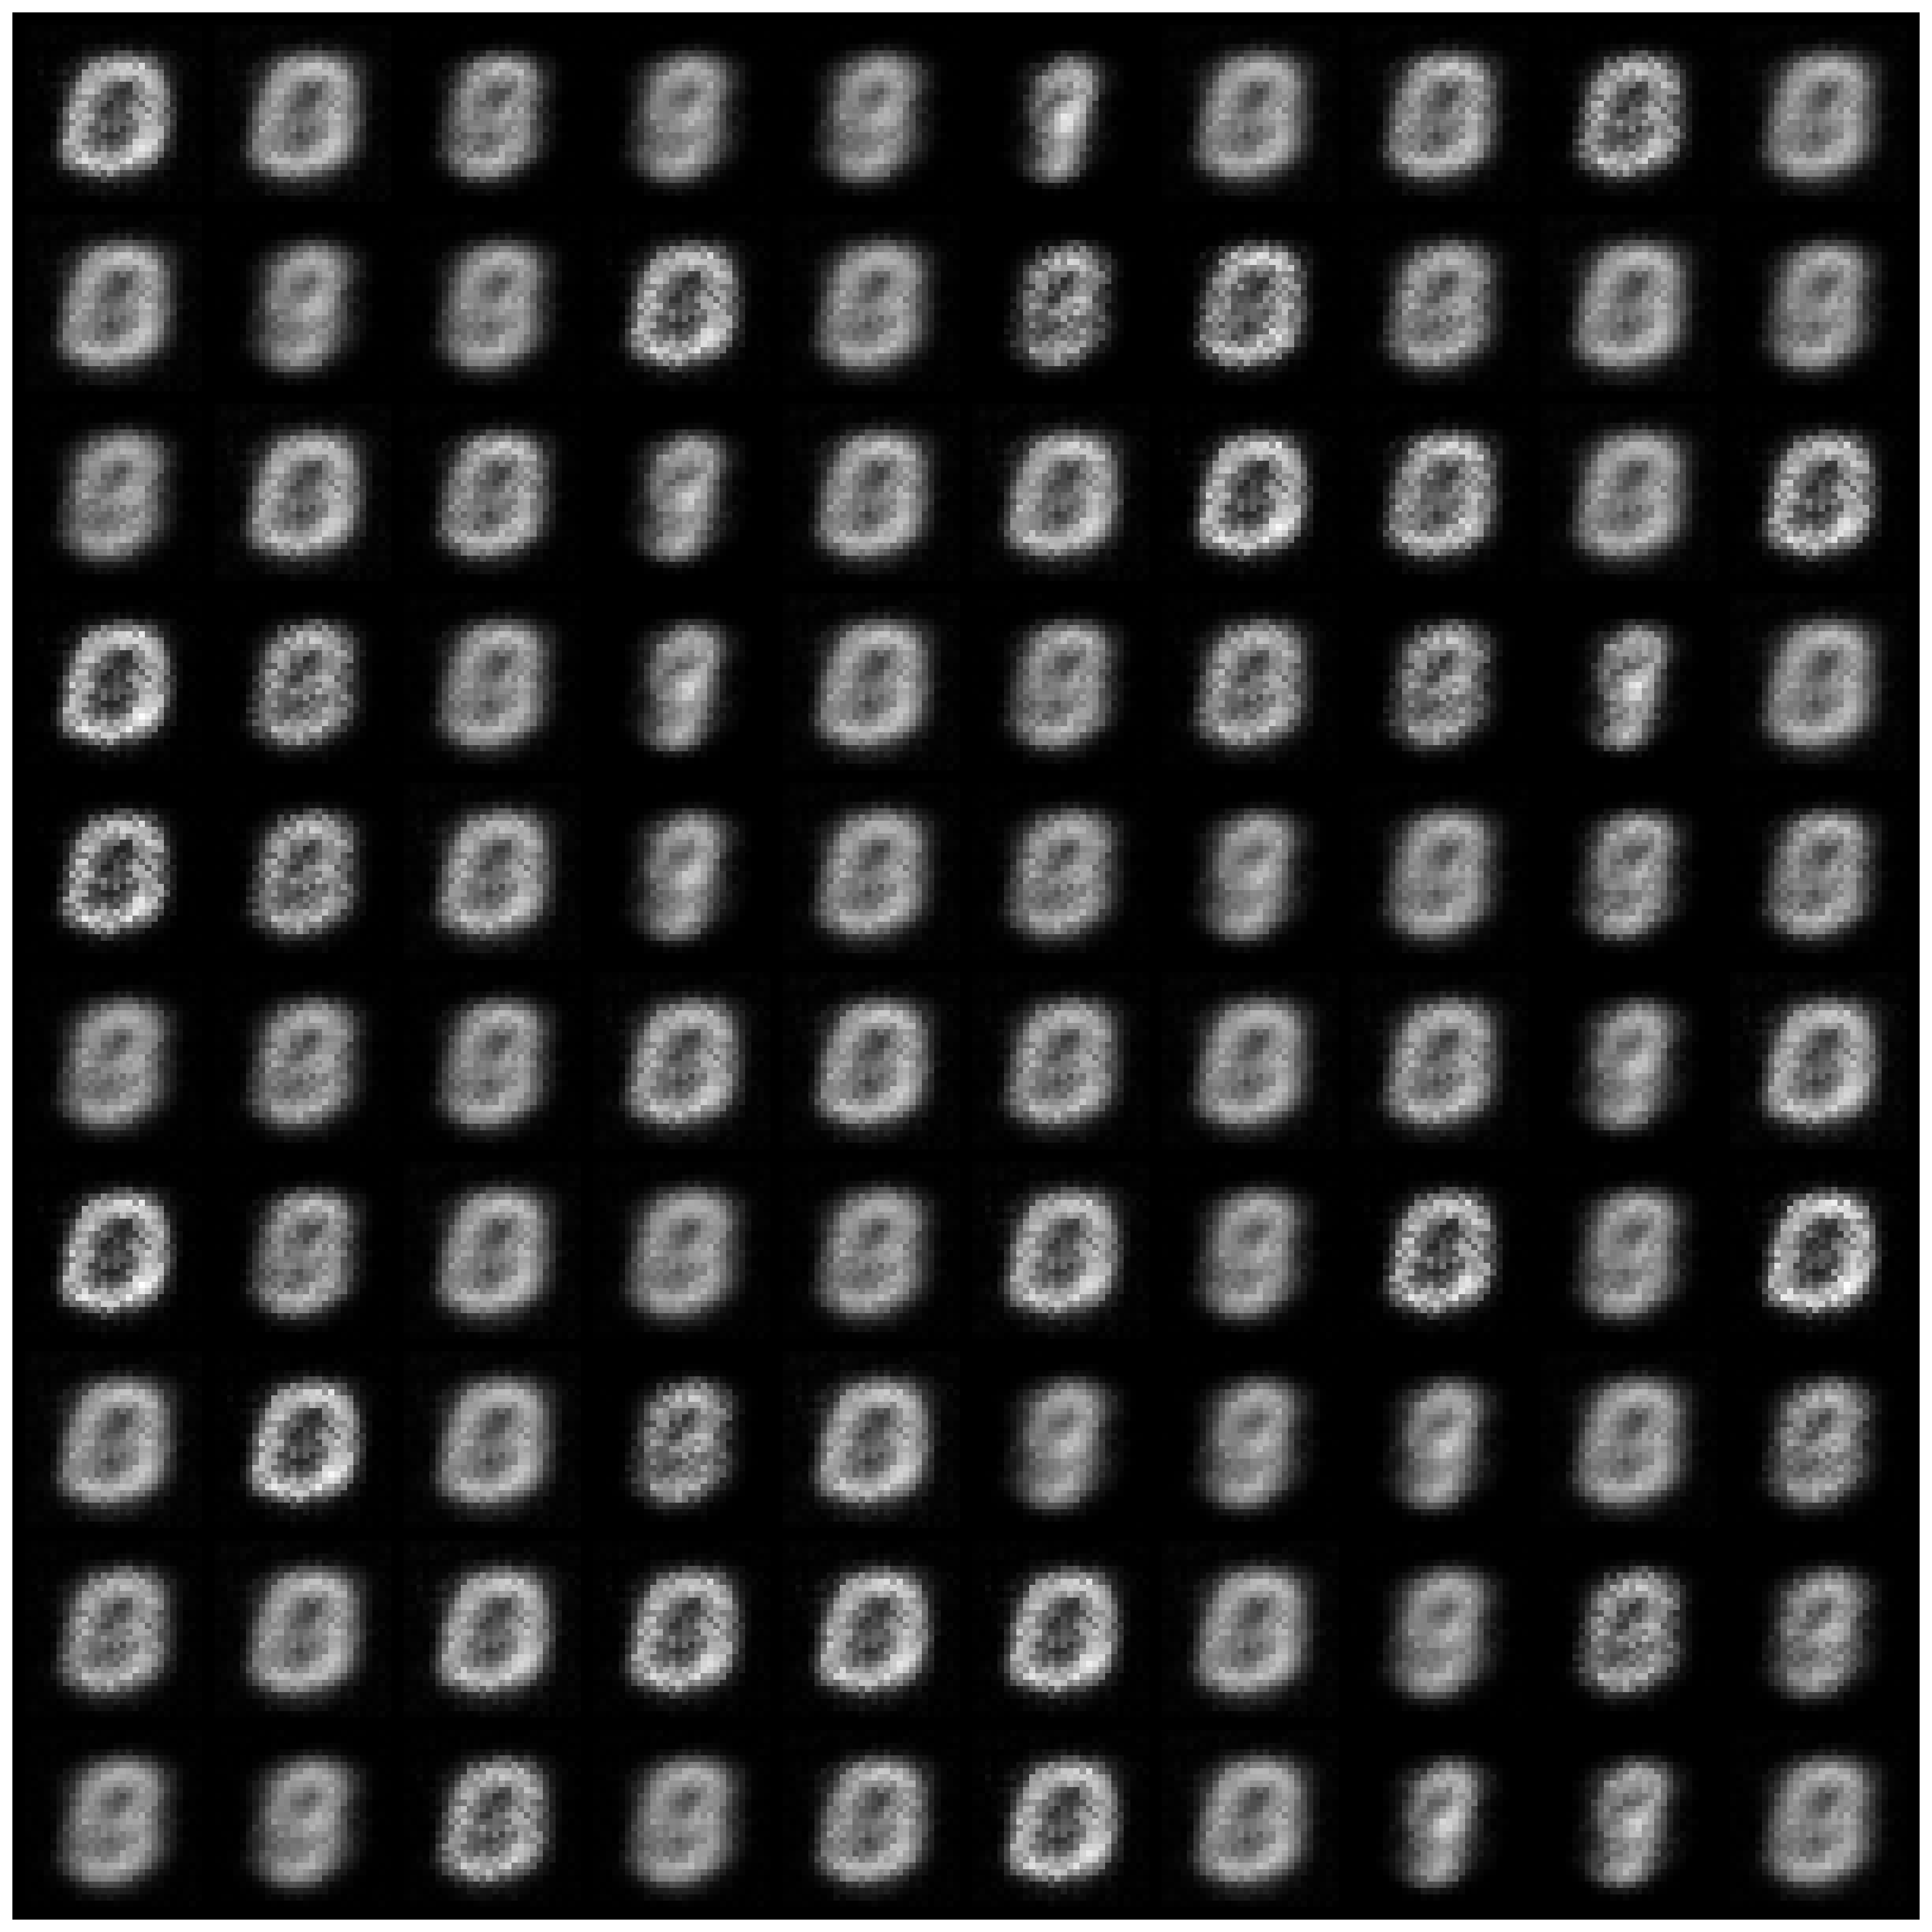

Train Epoch: 2 [0/60000 (0%)]	Loss: 197.543066
Train Epoch: 2 [10000/60000 (17%)]	Loss: 198.743613
Train Epoch: 2 [20000/60000 (33%)]	Loss: 188.999473
Train Epoch: 2 [30000/60000 (50%)]	Loss: 187.579590
Train Epoch: 2 [40000/60000 (67%)]	Loss: 195.559727
Train Epoch: 2 [50000/60000 (83%)]	Loss: 198.920273
====> Epoch: 2 Average loss: 194.1802
====> Test set loss: 192.0898


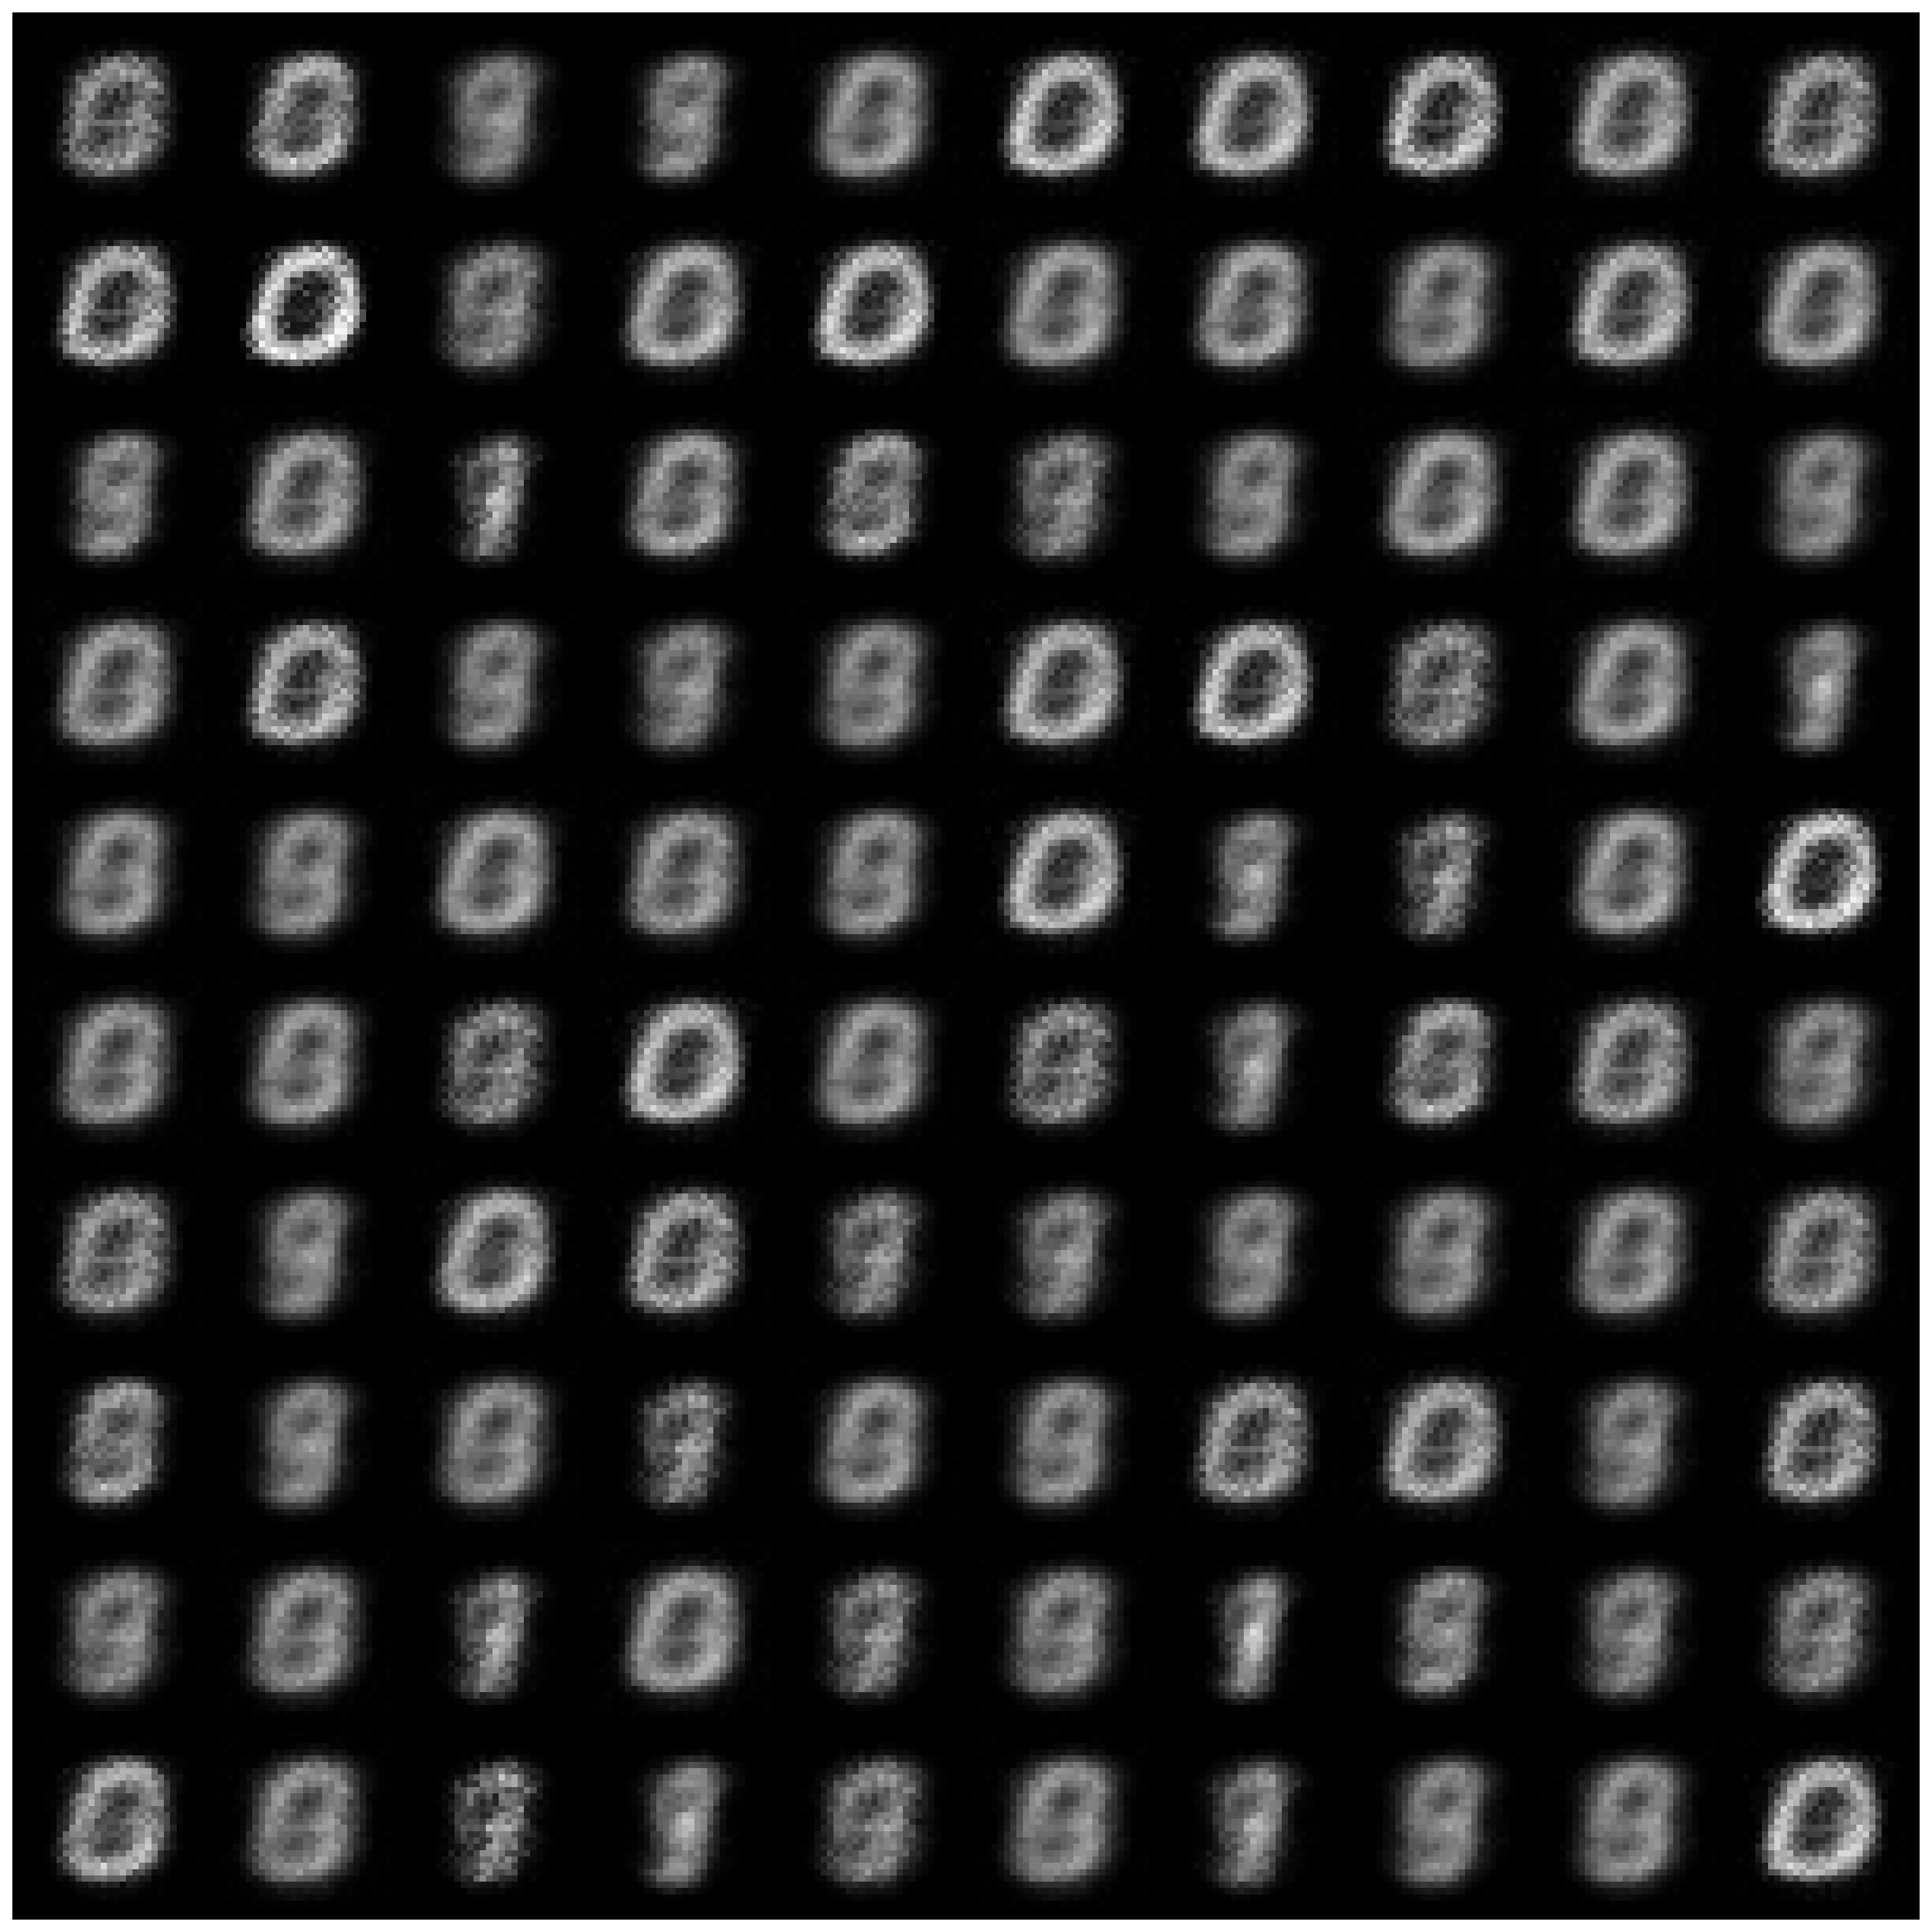

Train Epoch: 3 [0/60000 (0%)]	Loss: 189.059395
Train Epoch: 3 [10000/60000 (17%)]	Loss: 187.386465
Train Epoch: 3 [20000/60000 (33%)]	Loss: 192.969531
Train Epoch: 3 [30000/60000 (50%)]	Loss: 188.675195
Train Epoch: 3 [40000/60000 (67%)]	Loss: 187.725156
Train Epoch: 3 [50000/60000 (83%)]	Loss: 190.125742
====> Epoch: 3 Average loss: 189.2060
====> Test set loss: 184.9106


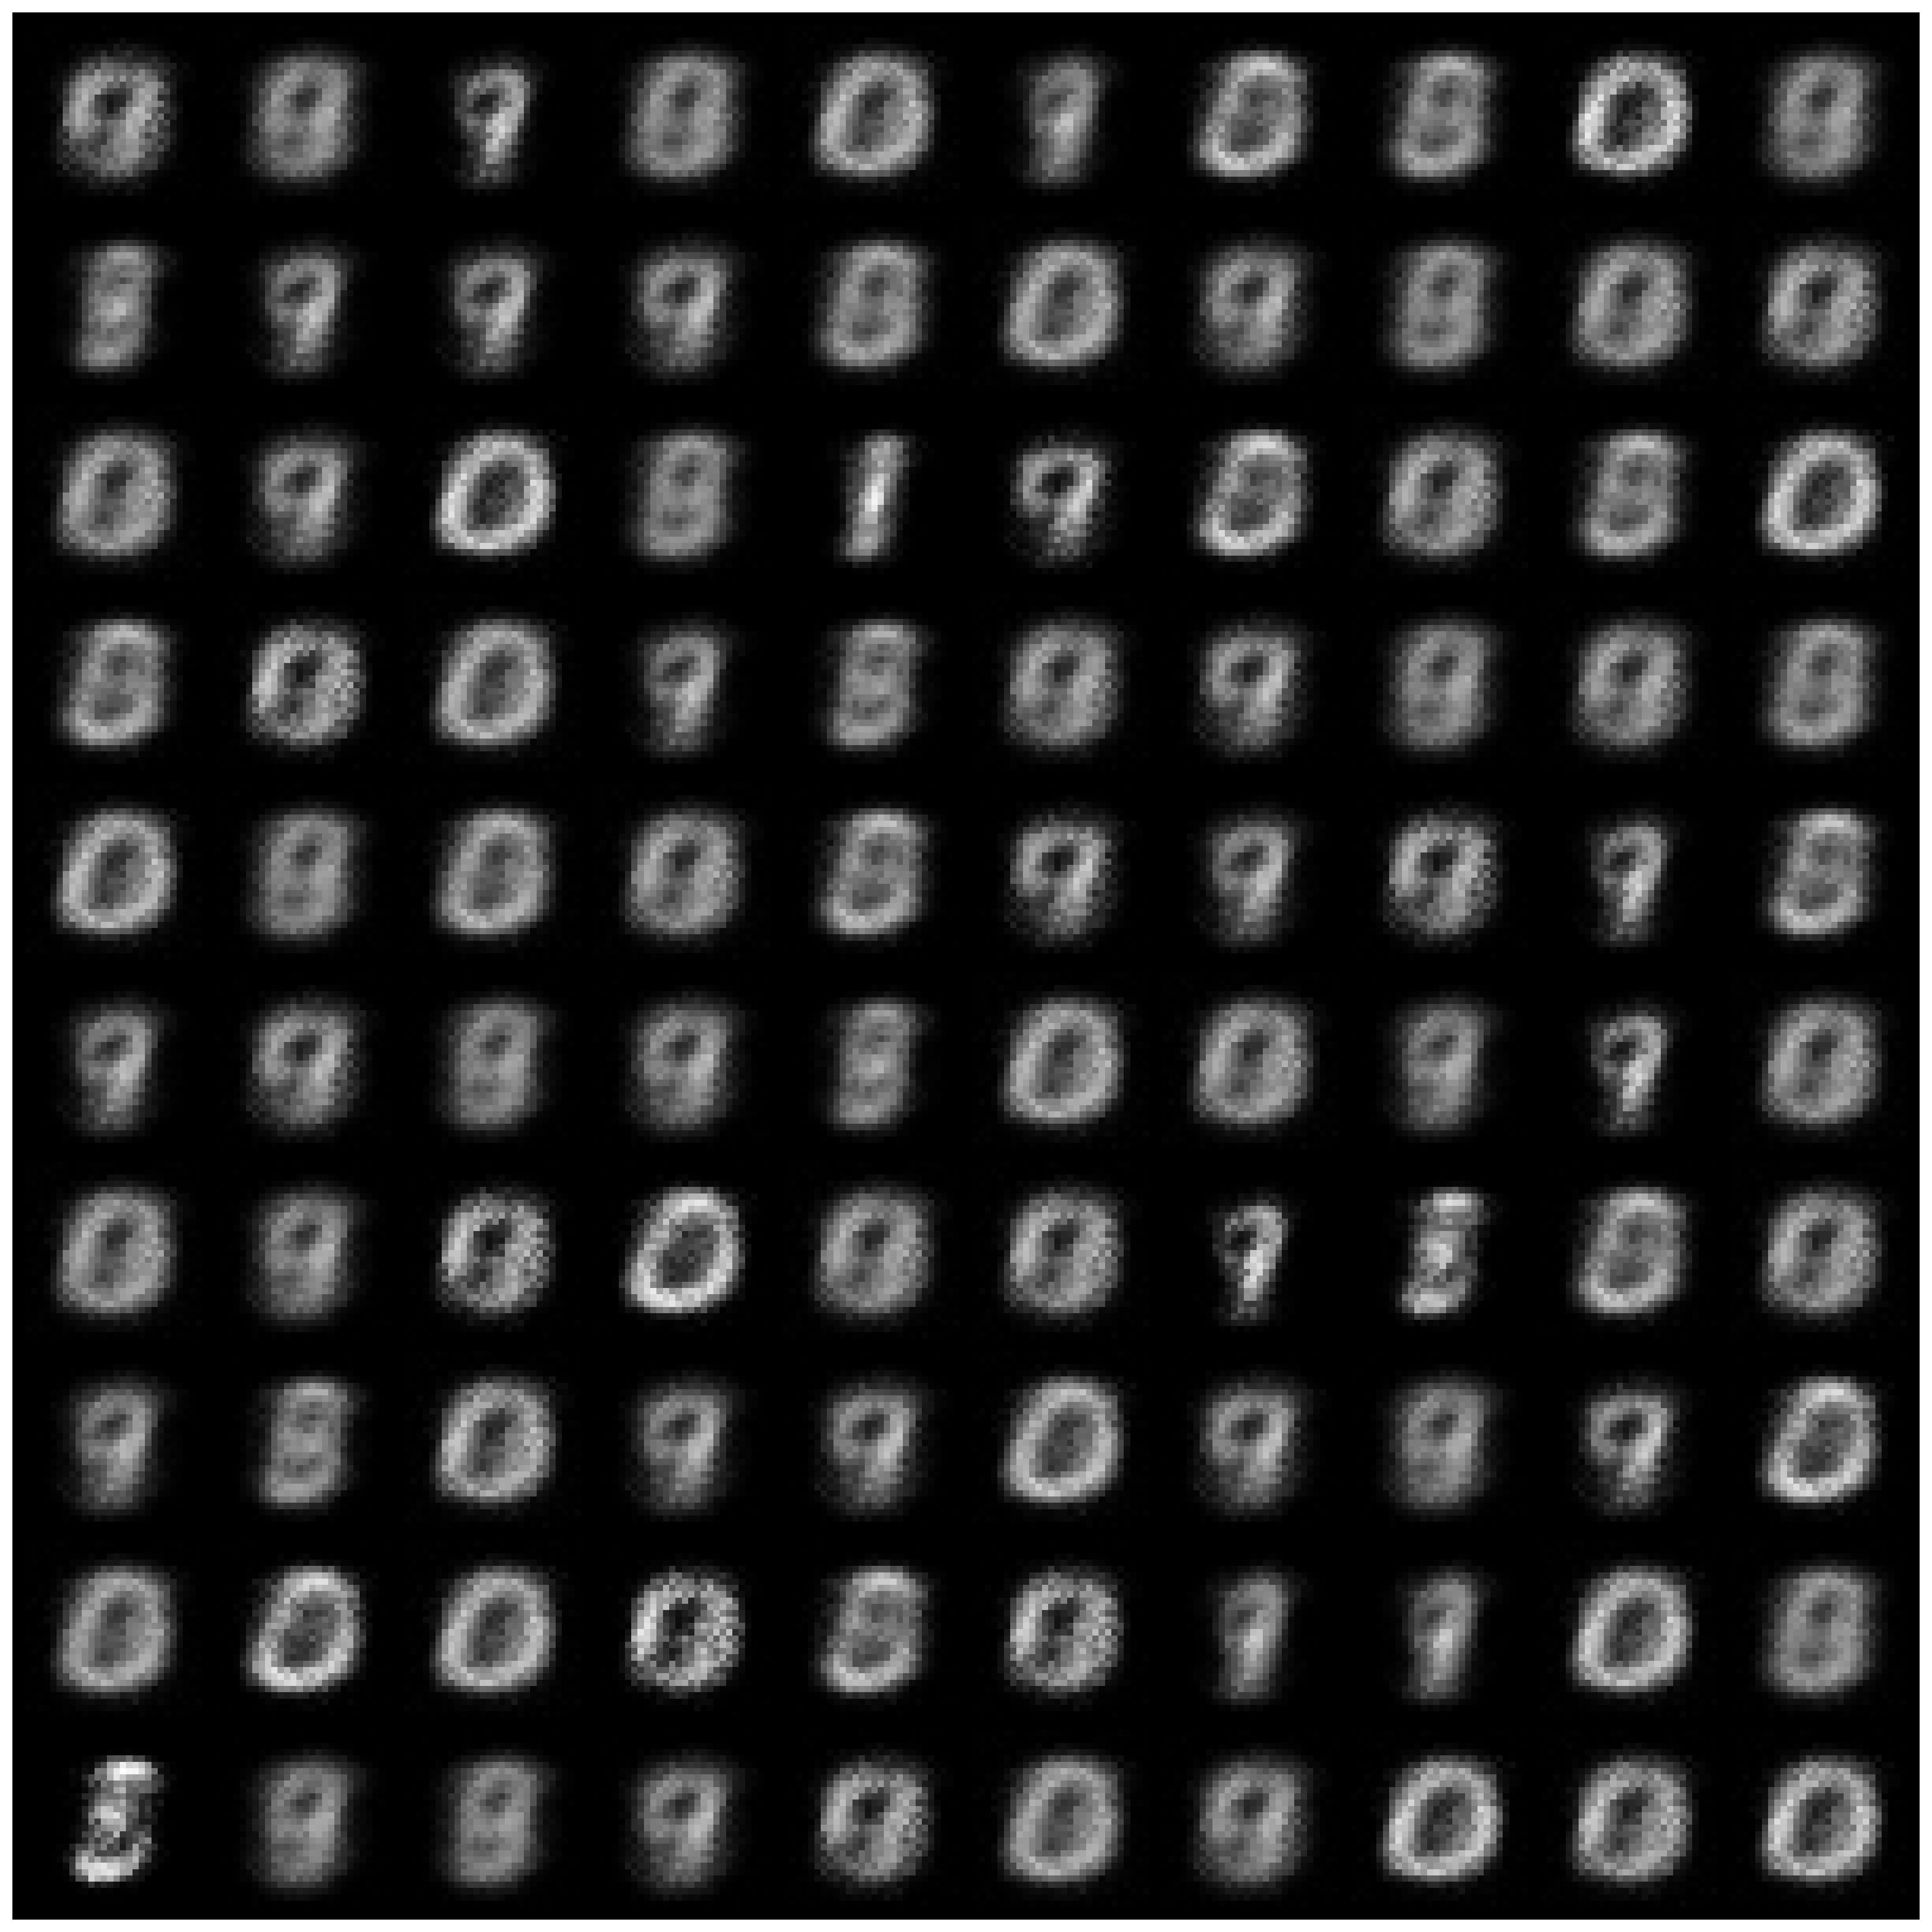

Train Epoch: 4 [0/60000 (0%)]	Loss: 186.772773
Train Epoch: 4 [10000/60000 (17%)]	Loss: 183.555469
Train Epoch: 4 [20000/60000 (33%)]	Loss: 189.950156
Train Epoch: 4 [30000/60000 (50%)]	Loss: 176.720996
Train Epoch: 4 [40000/60000 (67%)]	Loss: 177.173613
Train Epoch: 4 [50000/60000 (83%)]	Loss: 179.914727
====> Epoch: 4 Average loss: 183.9528
====> Test set loss: 181.7022


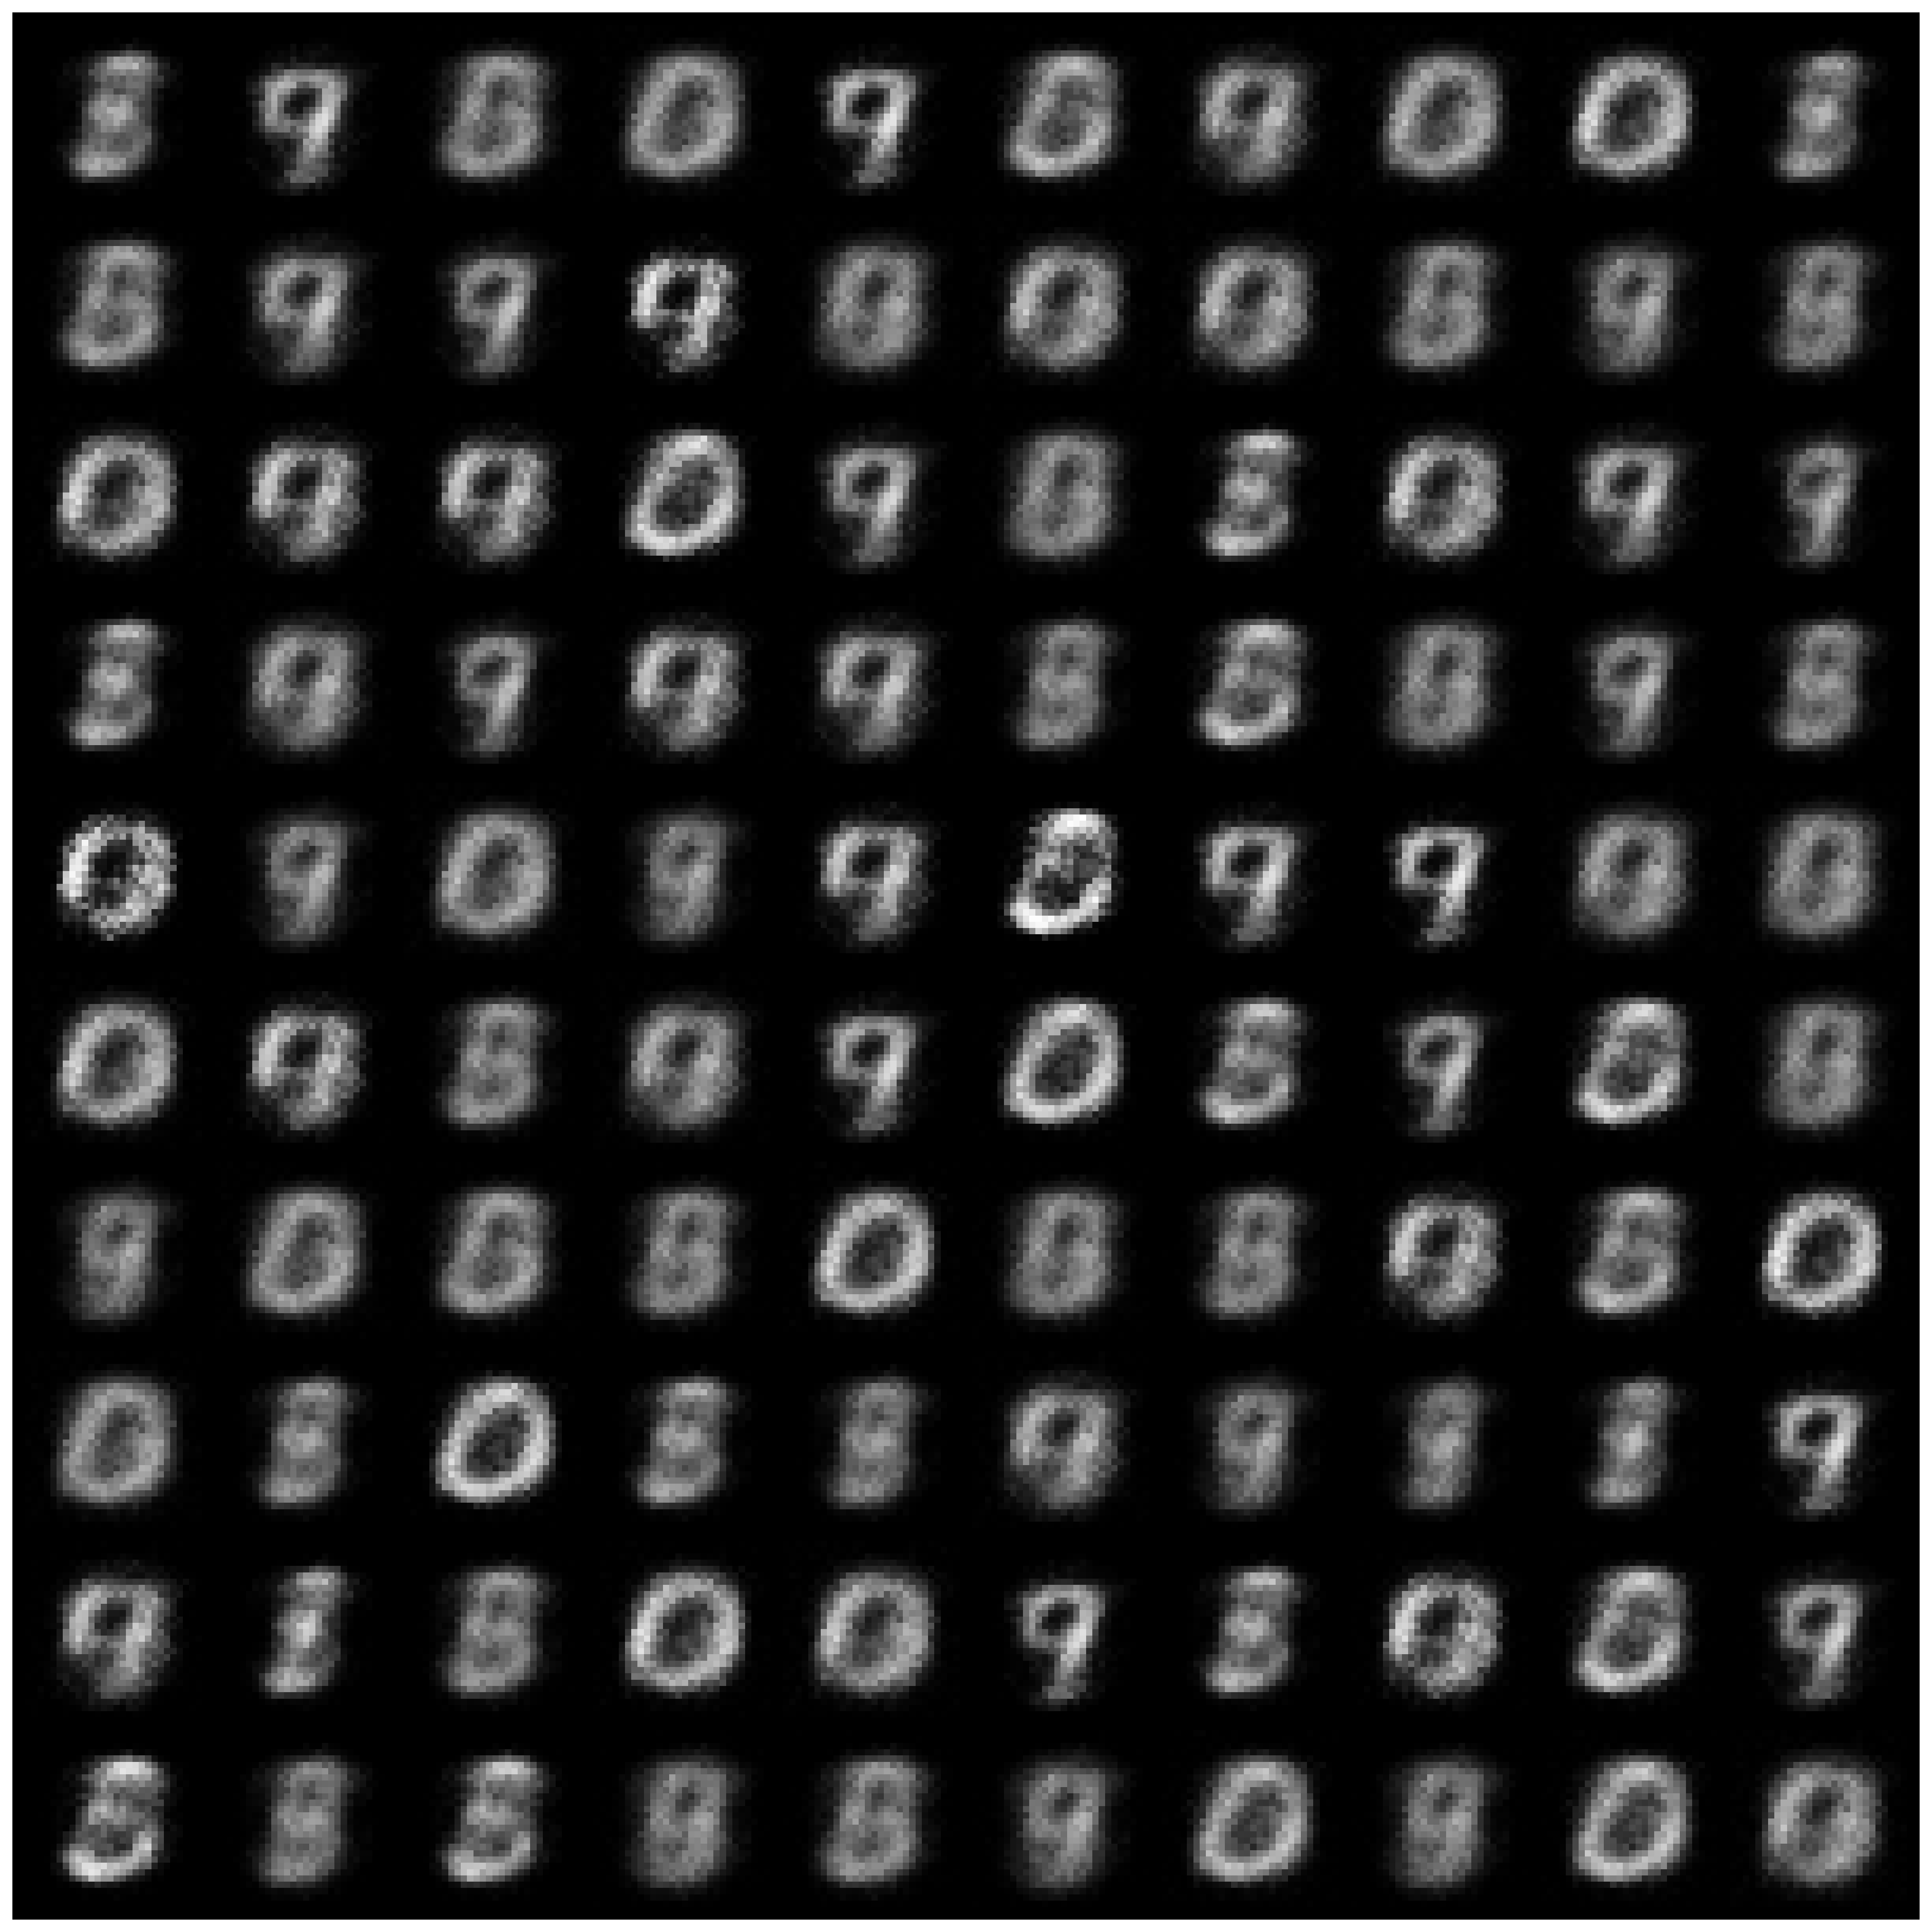

Train Epoch: 5 [0/60000 (0%)]	Loss: 184.383750
Train Epoch: 5 [10000/60000 (17%)]	Loss: 180.185313
Train Epoch: 5 [20000/60000 (33%)]	Loss: 189.376309
Train Epoch: 5 [30000/60000 (50%)]	Loss: 184.637578
Train Epoch: 5 [40000/60000 (67%)]	Loss: 184.244434
Train Epoch: 5 [50000/60000 (83%)]	Loss: 185.393398
====> Epoch: 5 Average loss: 181.8140
====> Test set loss: 180.0478


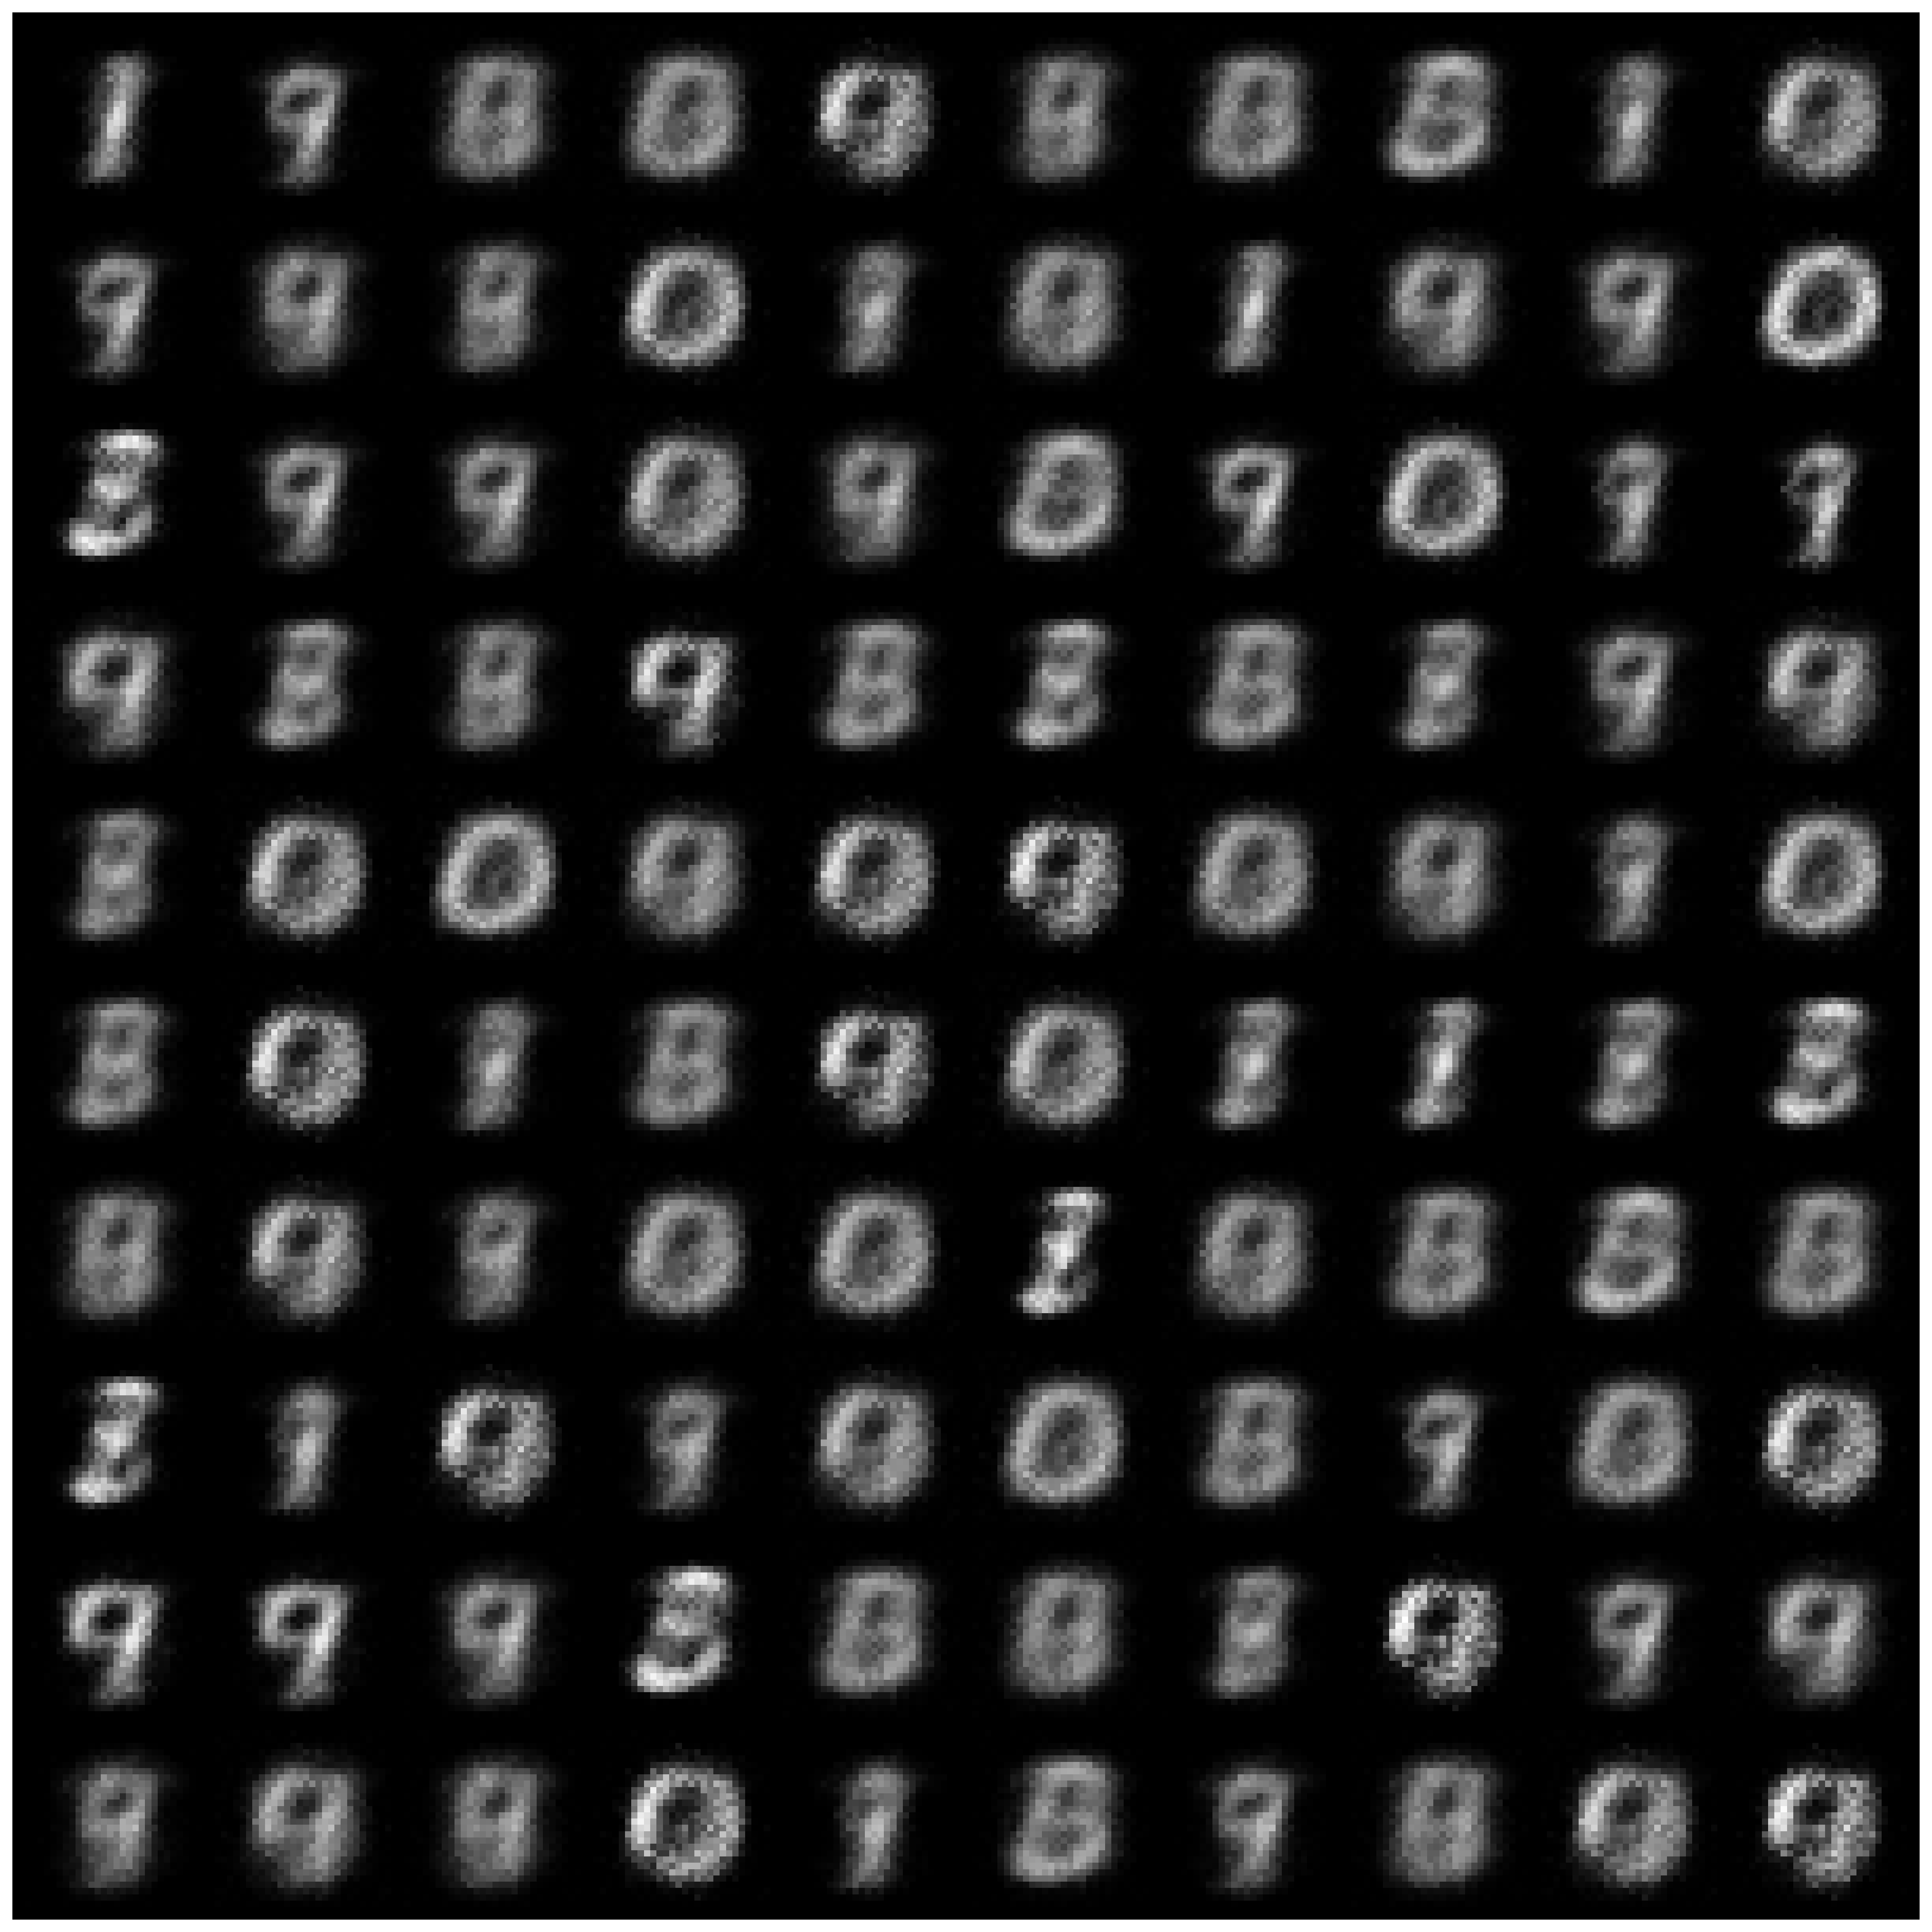

Train Epoch: 6 [0/60000 (0%)]	Loss: 177.356445
Train Epoch: 6 [10000/60000 (17%)]	Loss: 166.800879
Train Epoch: 6 [20000/60000 (33%)]	Loss: 187.812617
Train Epoch: 6 [30000/60000 (50%)]	Loss: 185.254297
Train Epoch: 6 [40000/60000 (67%)]	Loss: 180.594199
Train Epoch: 6 [50000/60000 (83%)]	Loss: 182.699258
====> Epoch: 6 Average loss: 180.6480
====> Test set loss: 179.1316


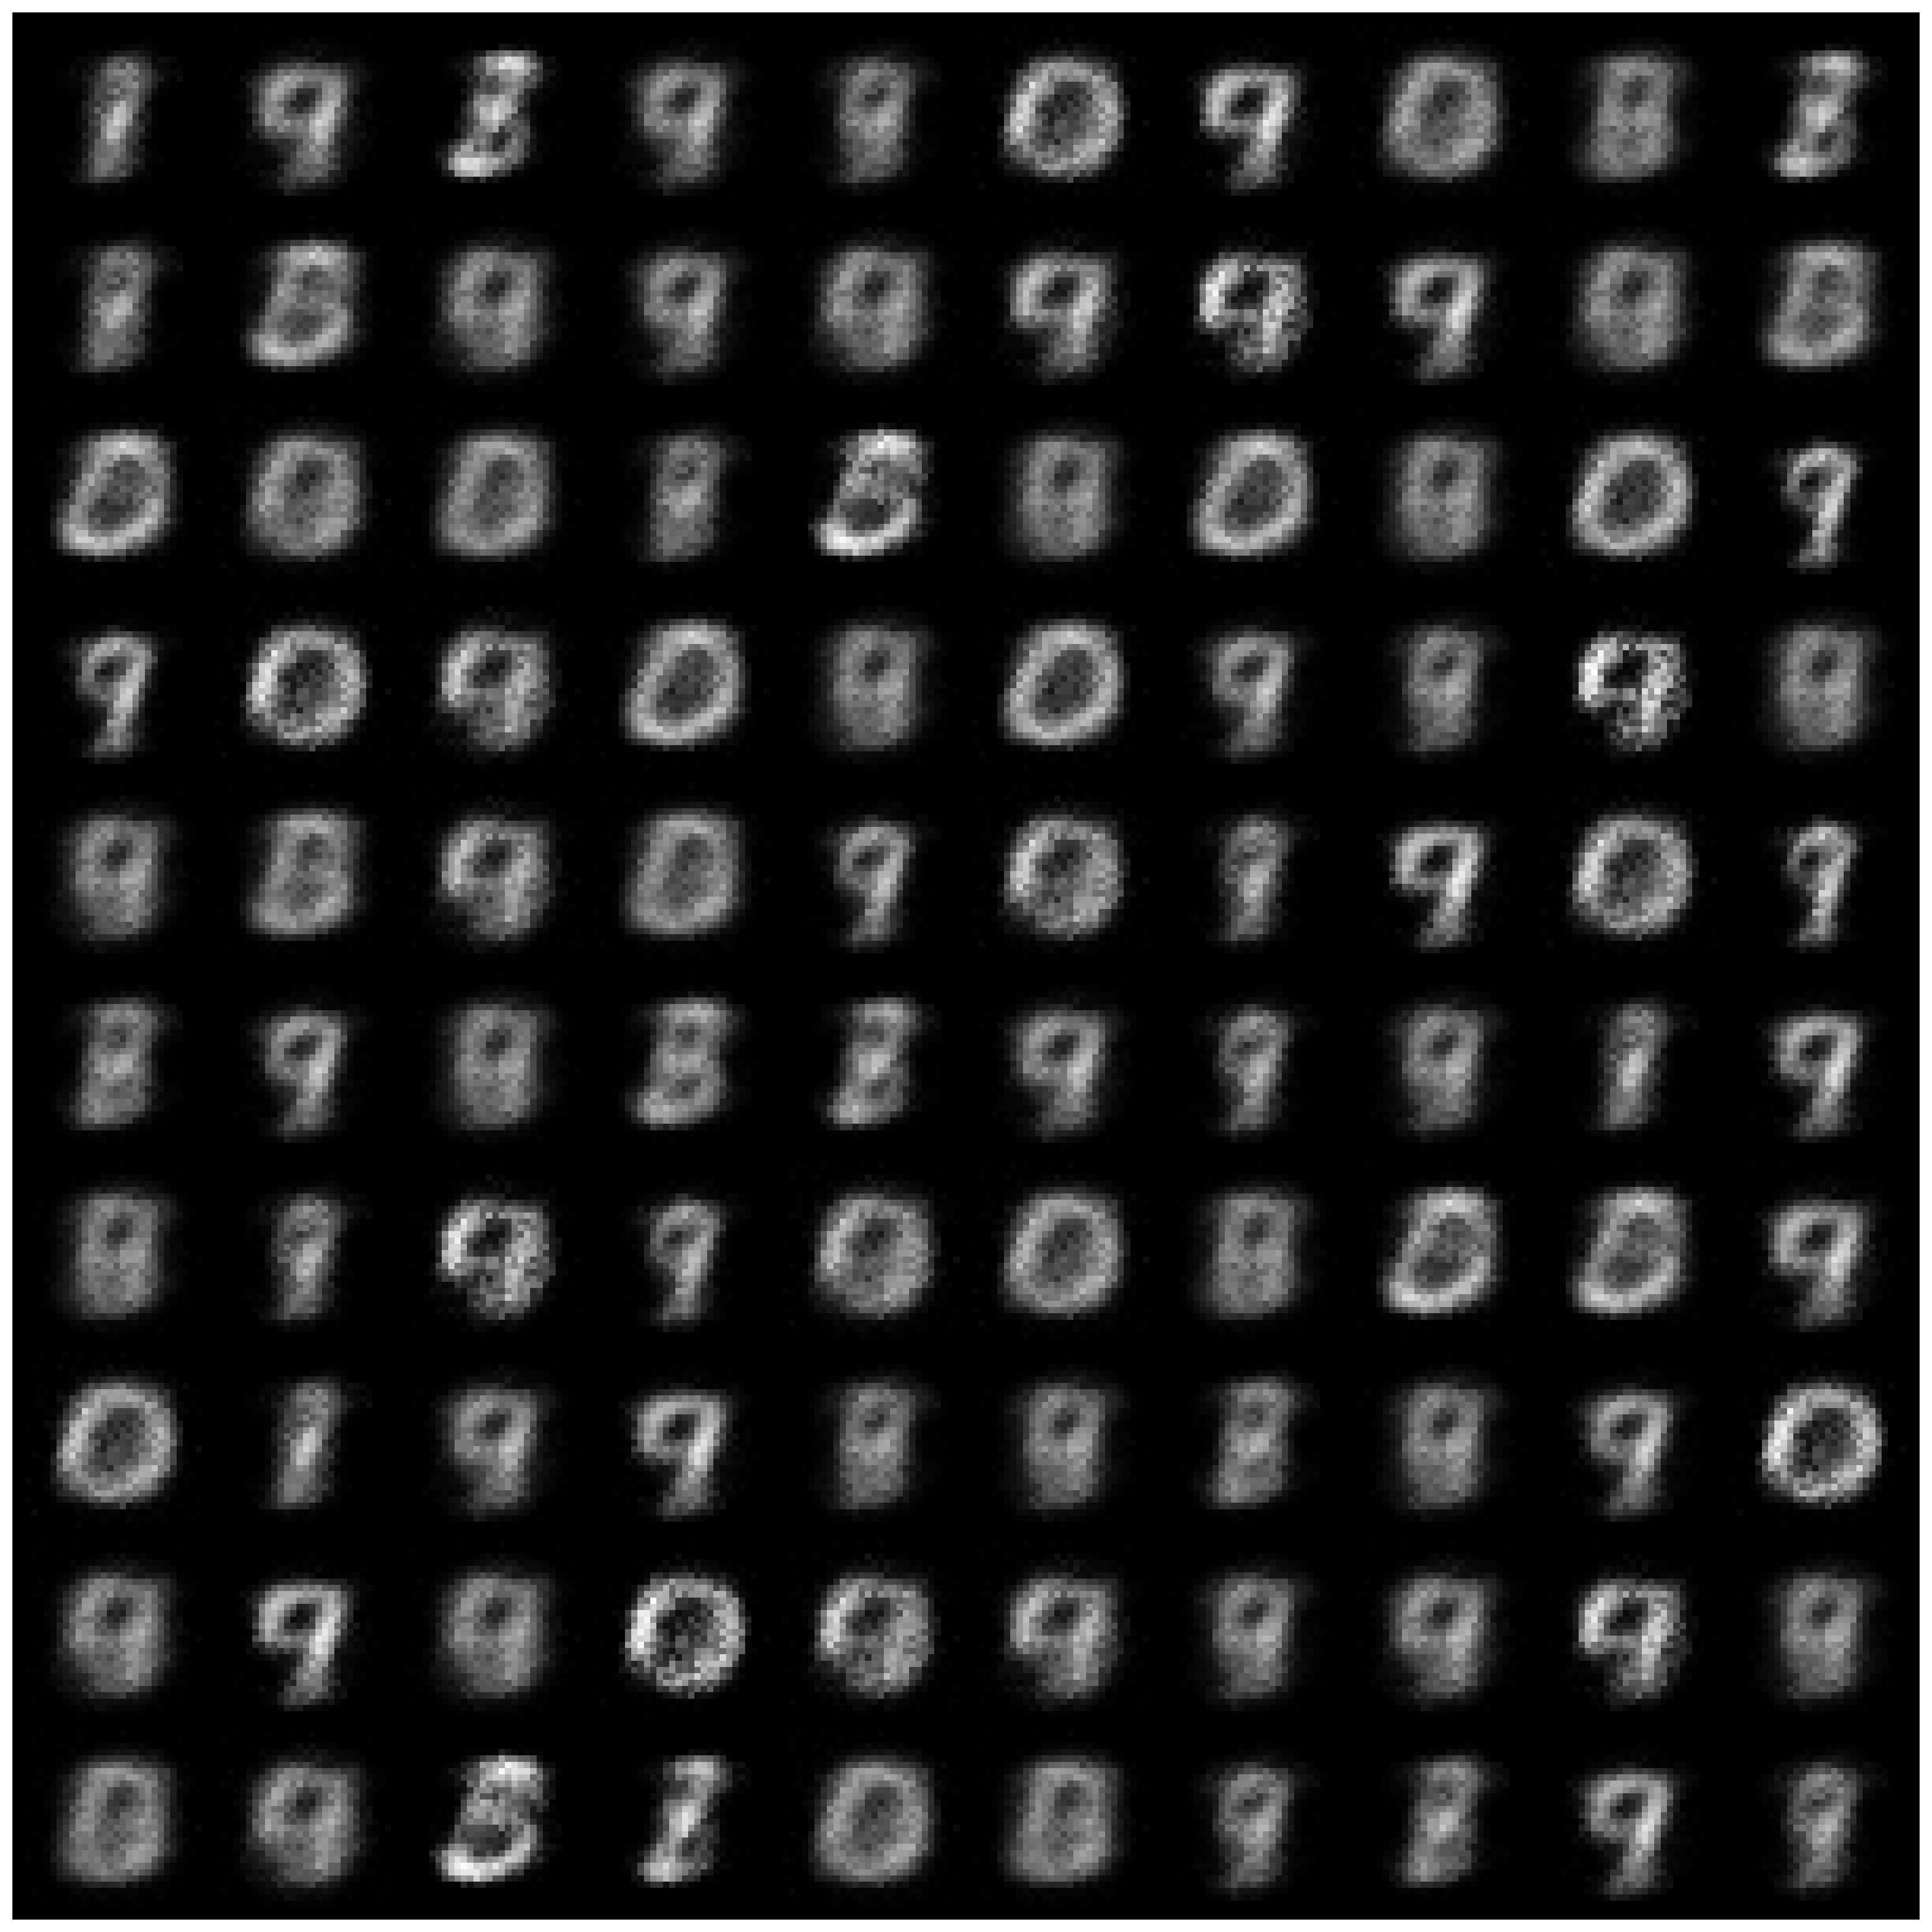

Train Epoch: 7 [0/60000 (0%)]	Loss: 186.135742
Train Epoch: 7 [10000/60000 (17%)]	Loss: 174.015137
Train Epoch: 7 [20000/60000 (33%)]	Loss: 174.819883
Train Epoch: 7 [30000/60000 (50%)]	Loss: 182.316289
Train Epoch: 7 [40000/60000 (67%)]	Loss: 171.736504
Train Epoch: 7 [50000/60000 (83%)]	Loss: 169.493223
====> Epoch: 7 Average loss: 179.6129
====> Test set loss: 178.2915


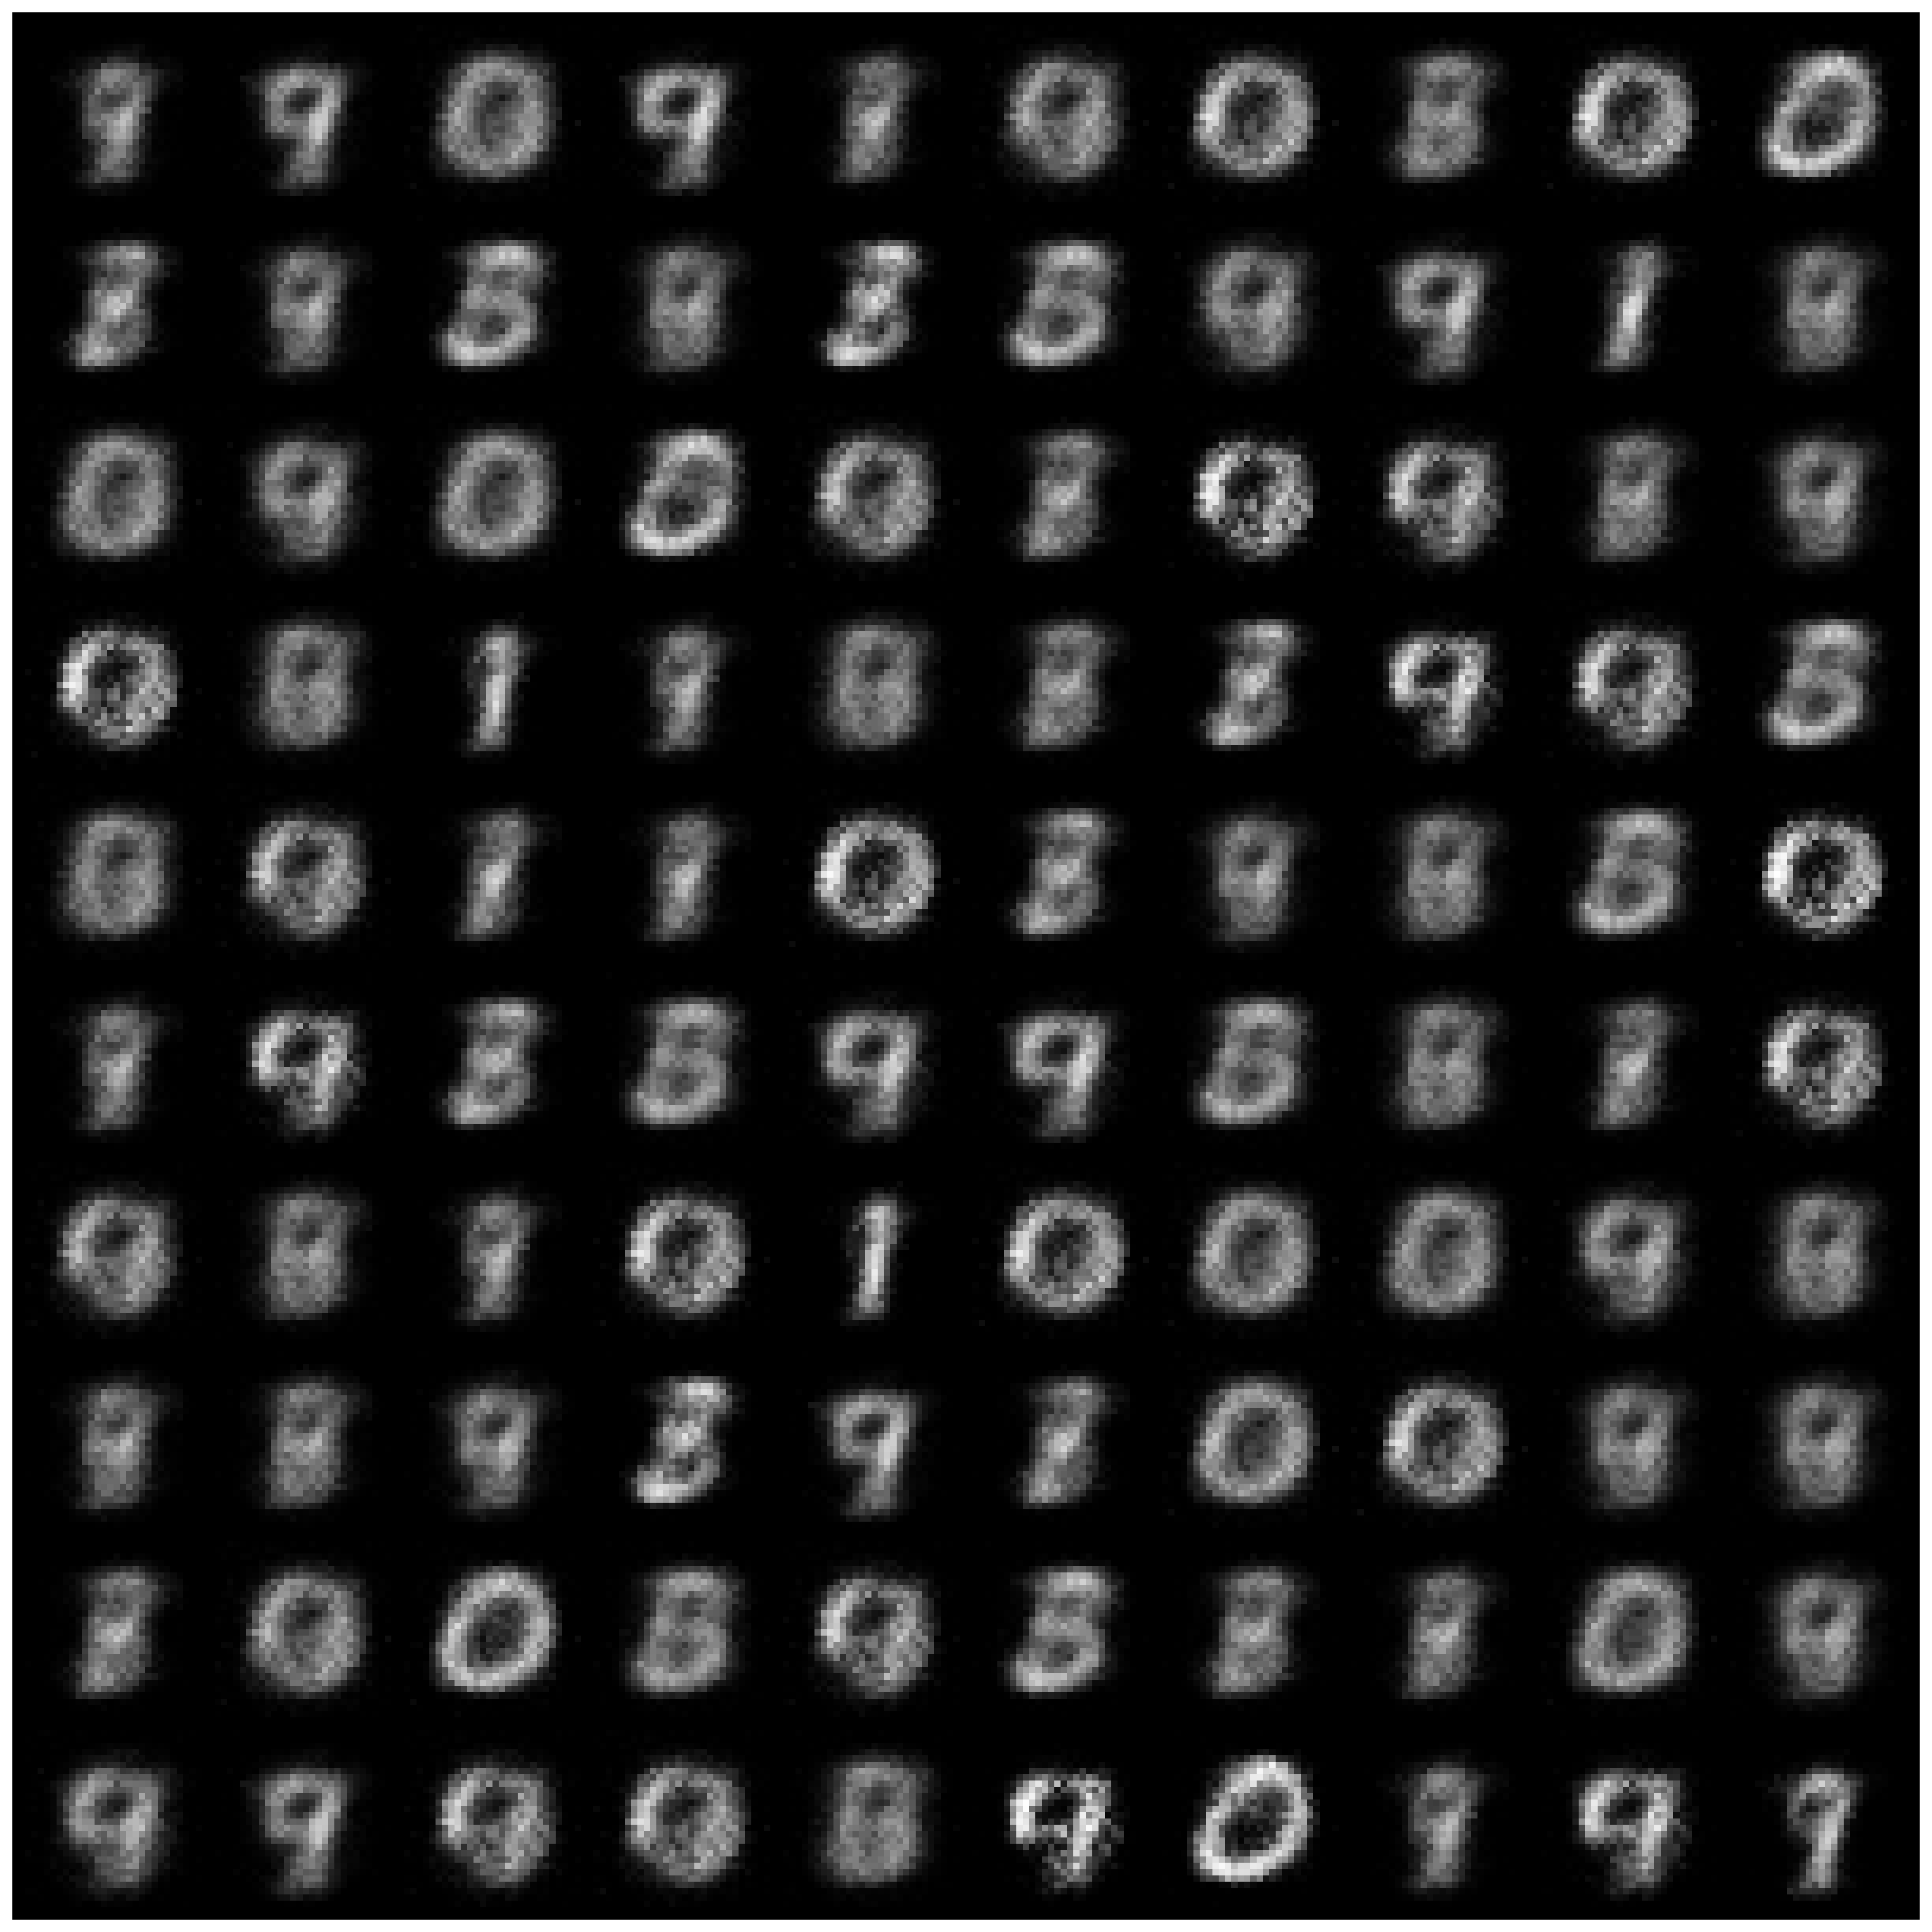

Train Epoch: 8 [0/60000 (0%)]	Loss: 178.034063
Train Epoch: 8 [10000/60000 (17%)]	Loss: 182.215937
Train Epoch: 8 [20000/60000 (33%)]	Loss: 187.677344
Train Epoch: 8 [30000/60000 (50%)]	Loss: 180.750254
Train Epoch: 8 [40000/60000 (67%)]	Loss: 184.899238
Train Epoch: 8 [50000/60000 (83%)]	Loss: 175.989746
====> Epoch: 8 Average loss: 178.9357
====> Test set loss: 177.7803


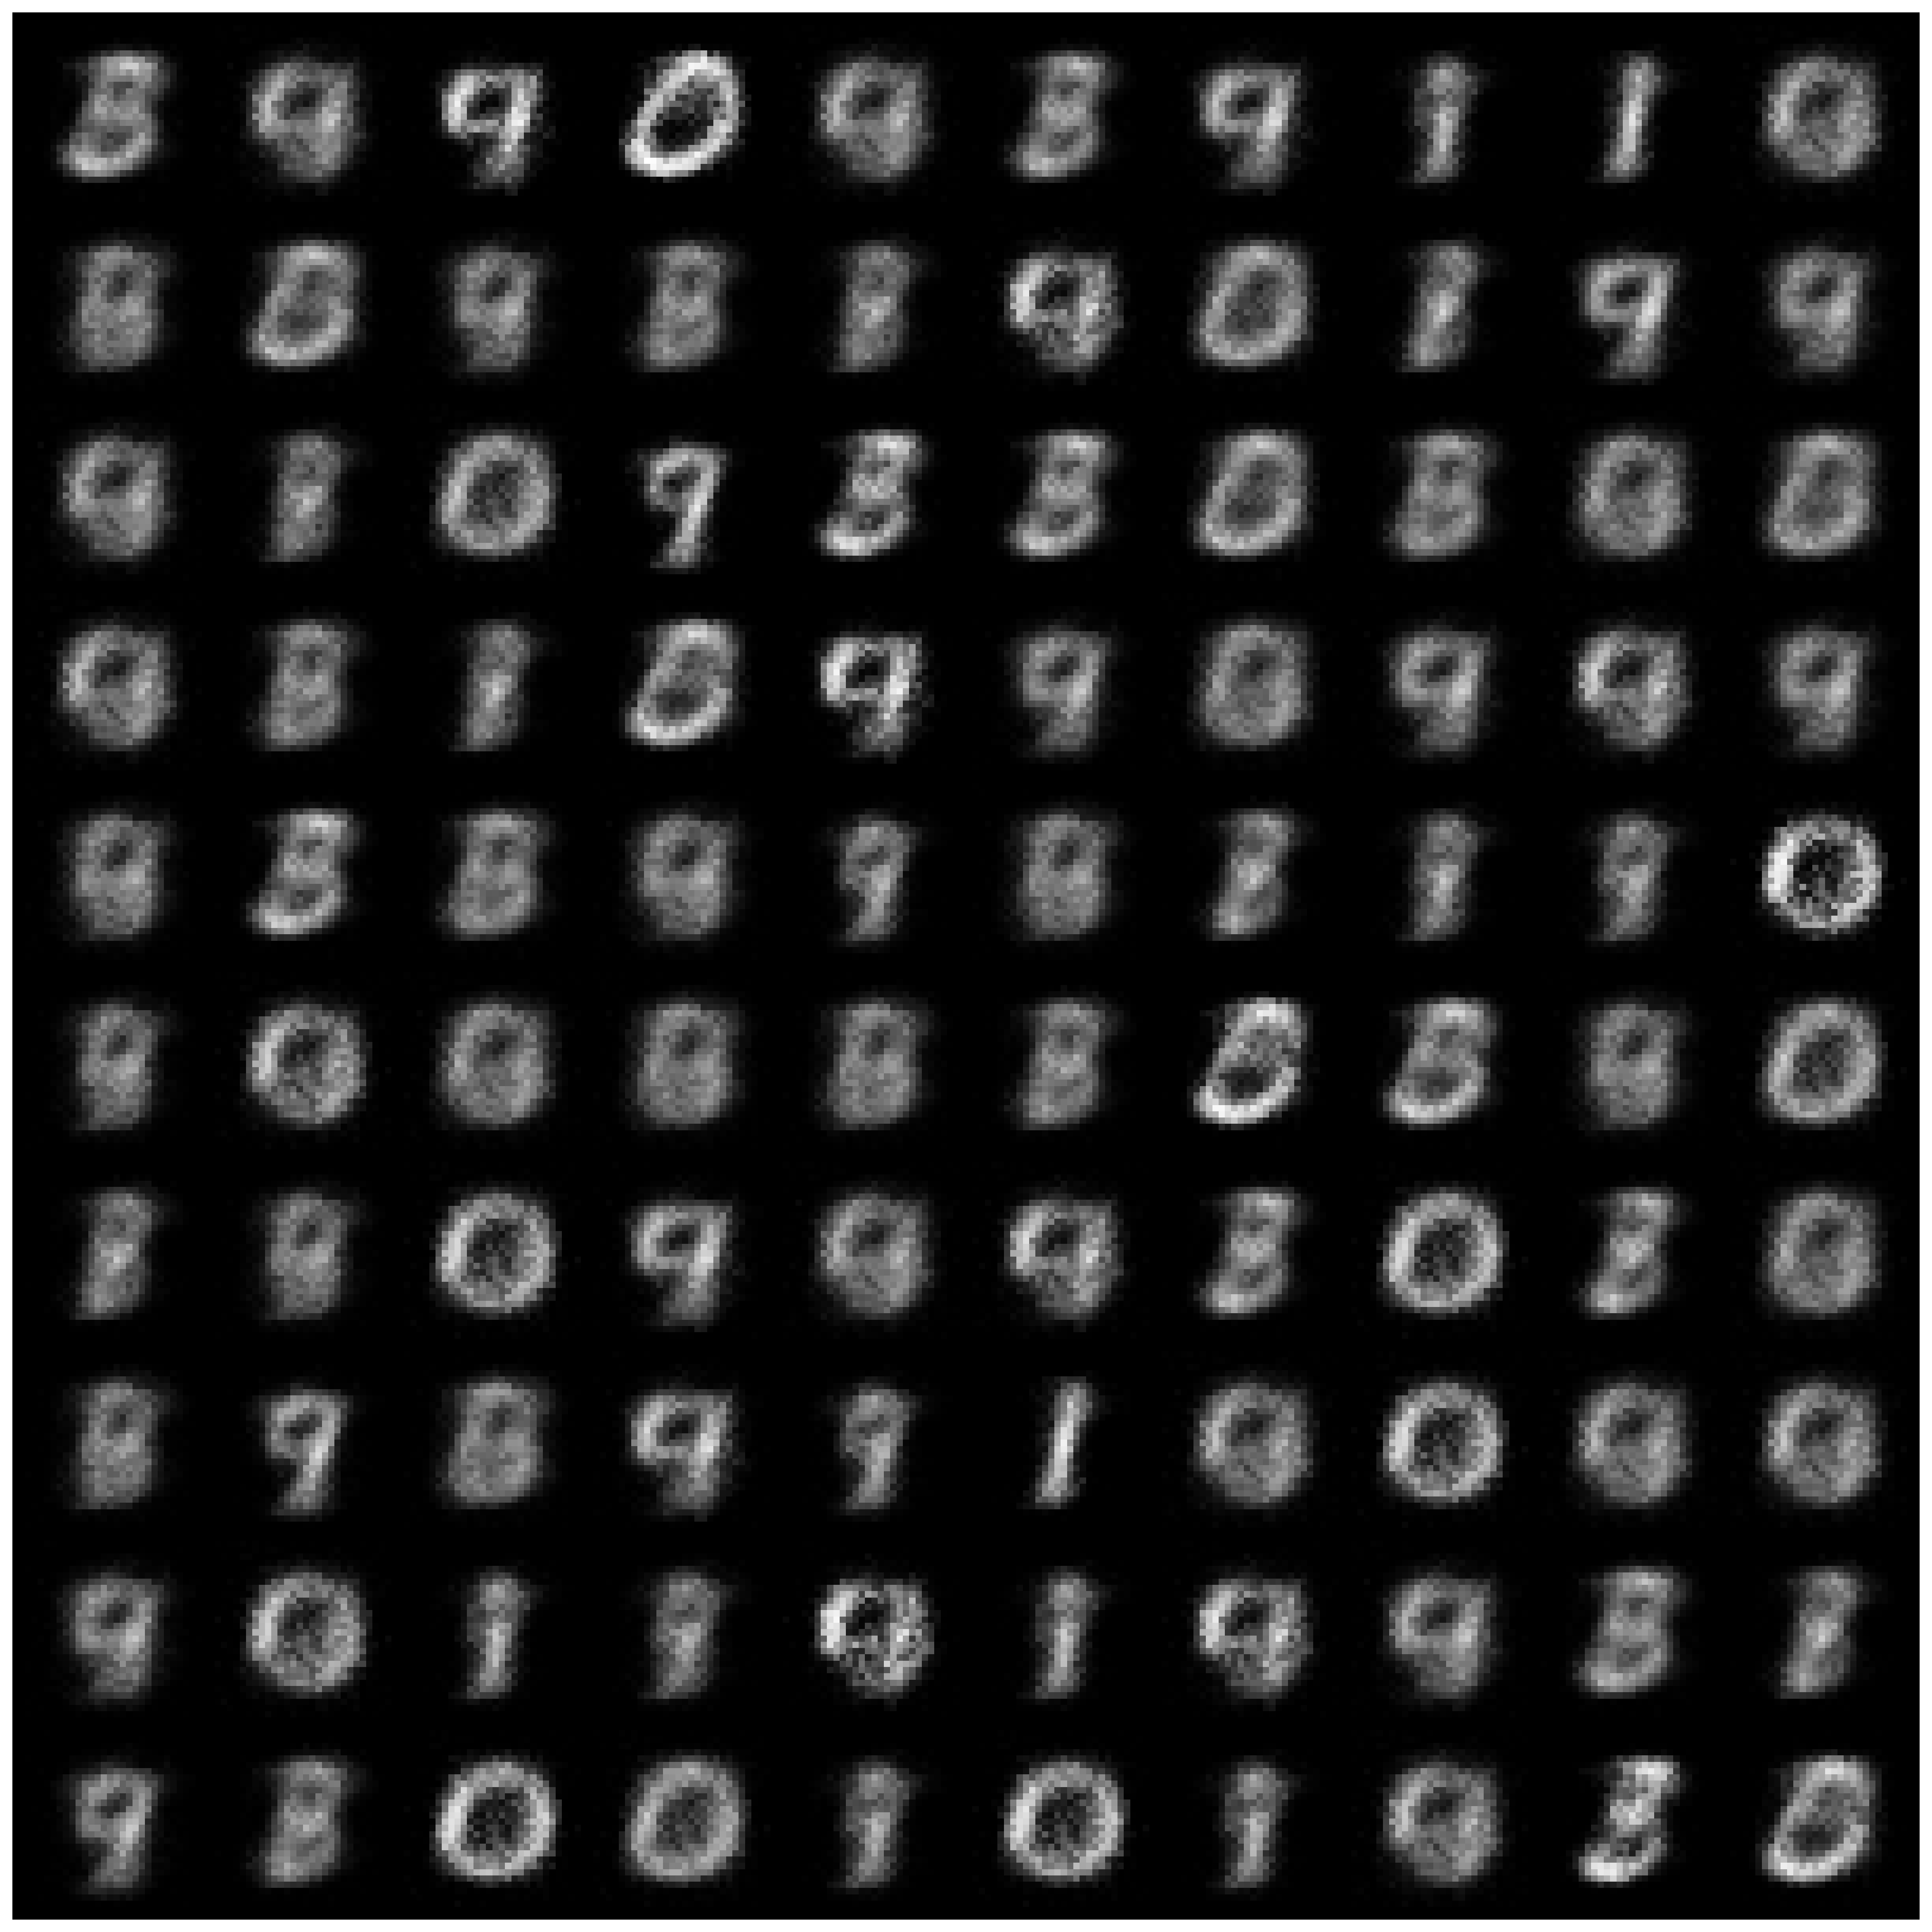

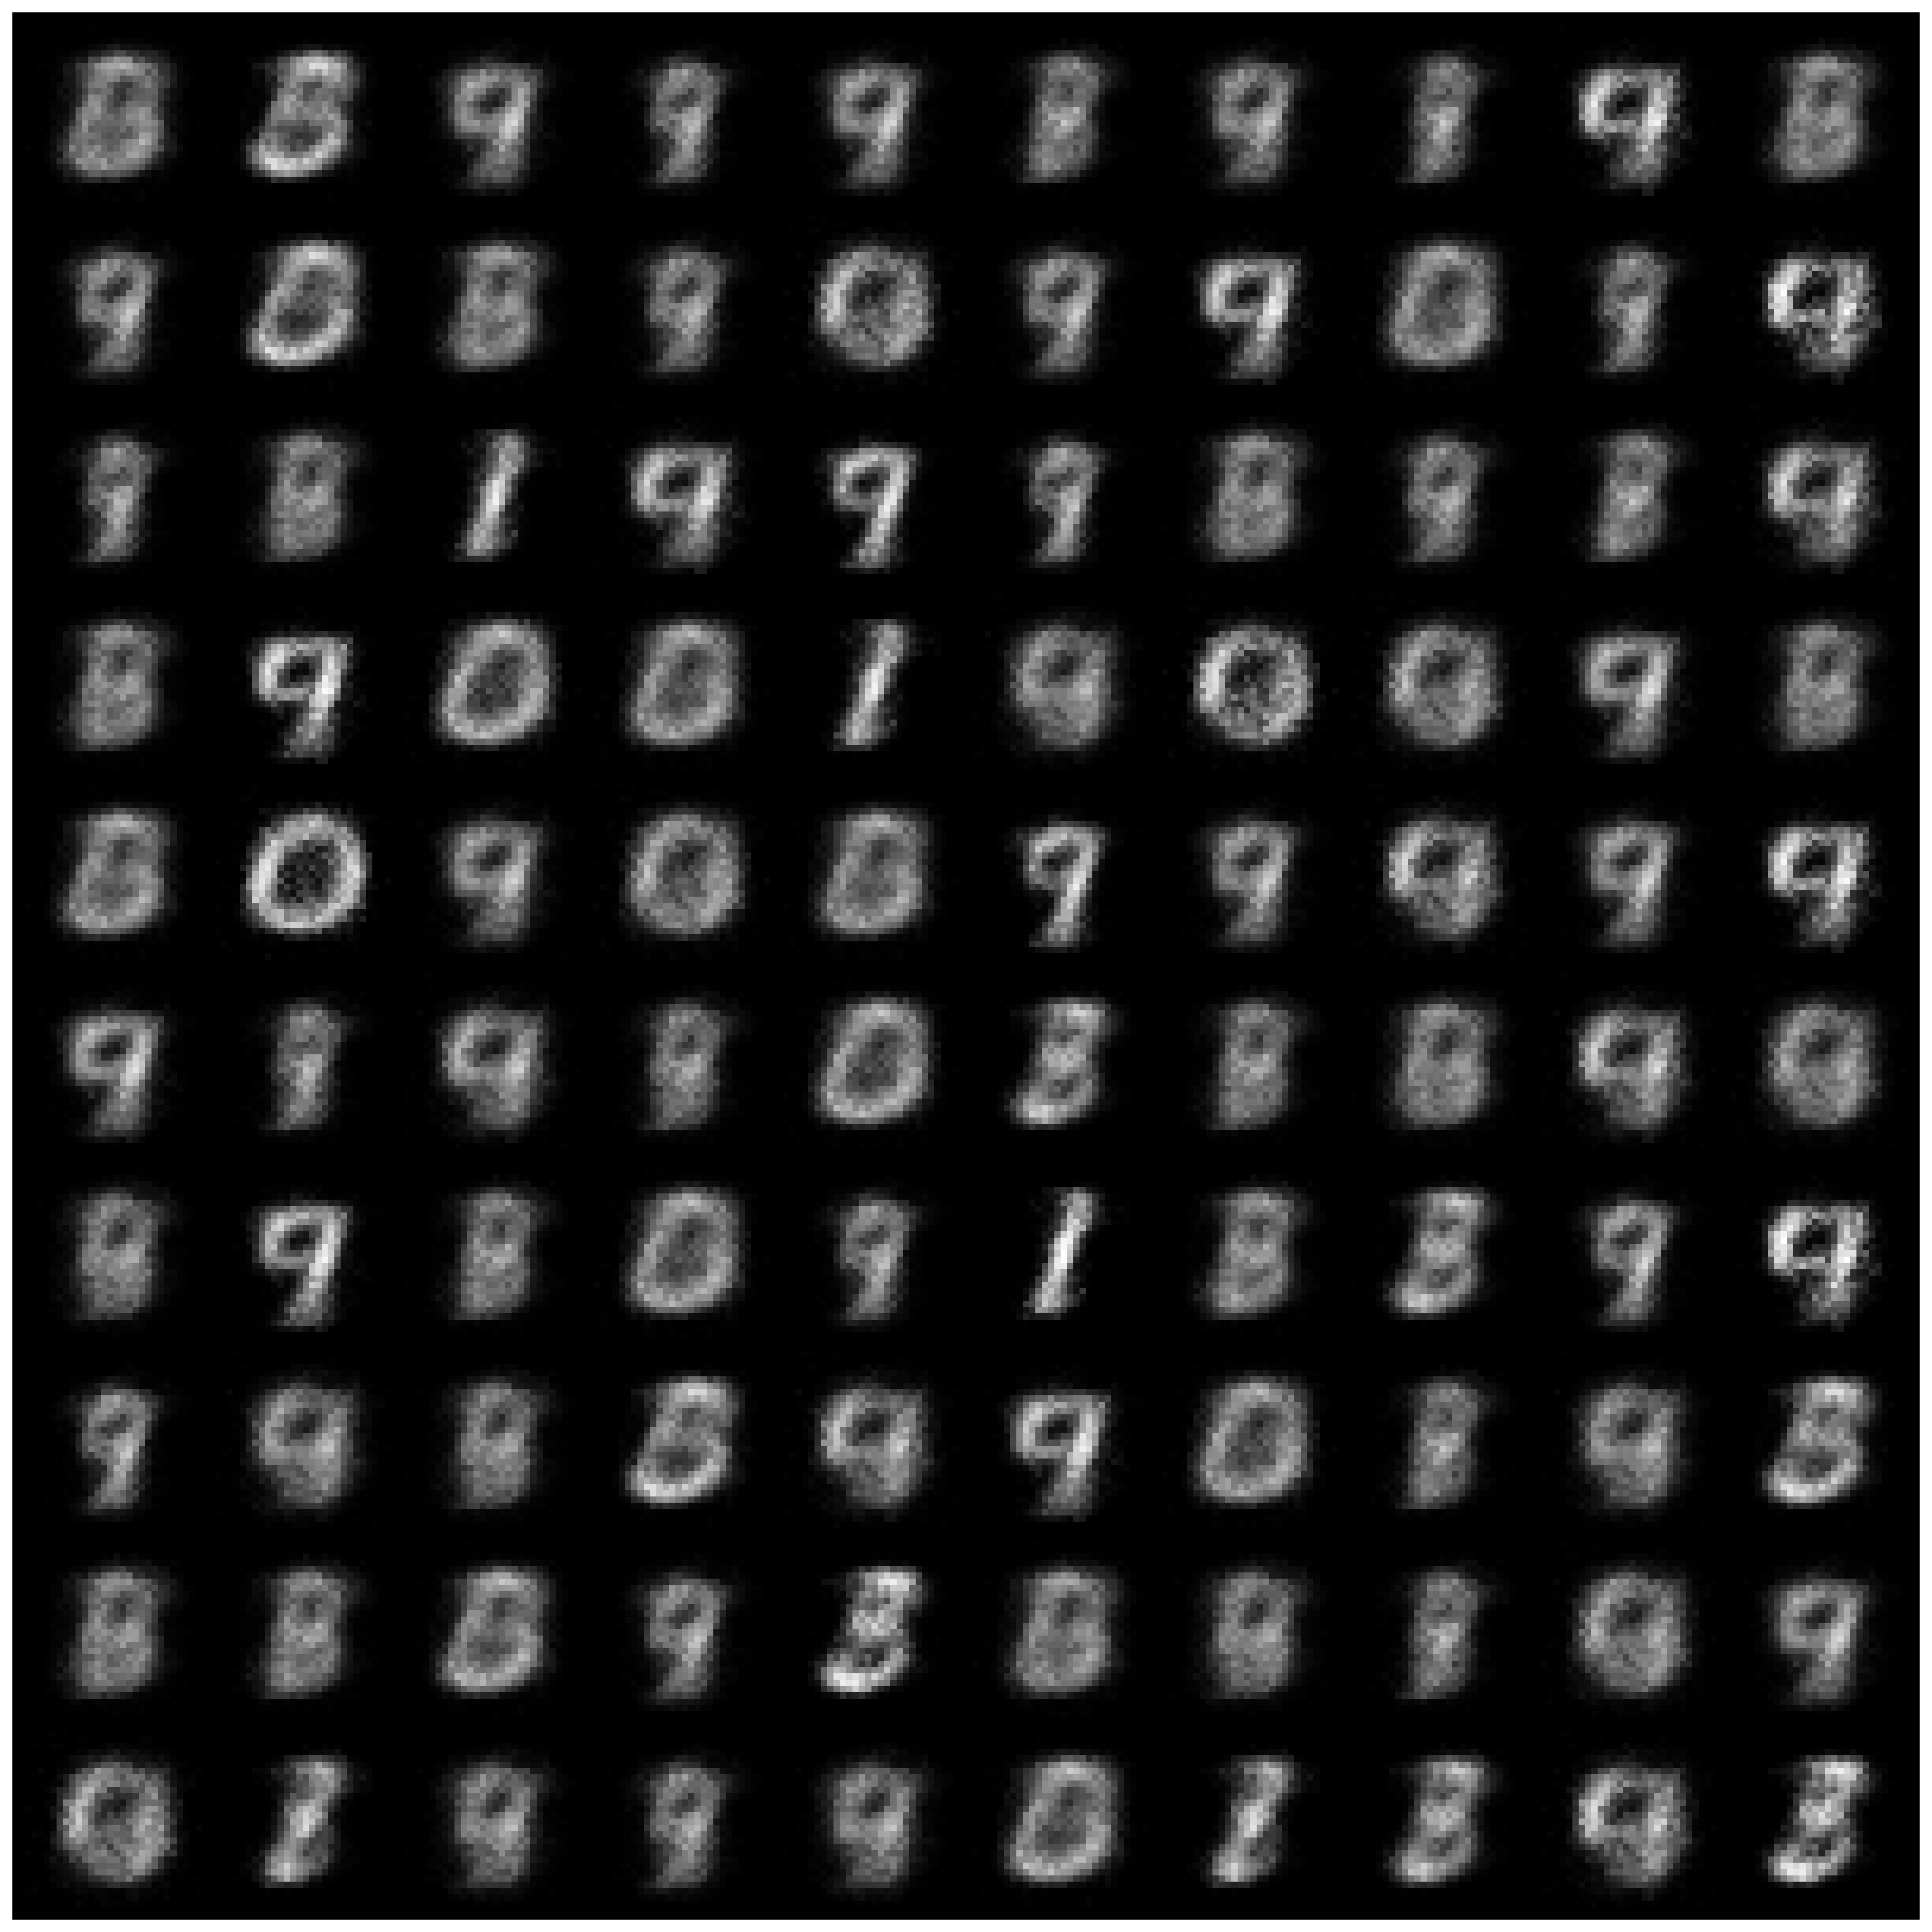

In [63]:

for epoch in range(epochs):
    train(epoch)
    test()

    with torch.no_grad():
        num_samples = 100
        samples = vae.sample(num_samples).detach().view(num_samples, 1, 28, 28)

        # Make a grid from the images
        grid = vutils.make_grid(samples, nrow=10, padding=2, normalize=True).cpu().detach()

        # Convert grid to numpy for plotting
        grid_np = grid.numpy().transpose((1, 2, 0))

        # Plot the grid
        plt.figure(figsize=(20, 20), dpi=300)
        plt.imshow(grid_np, cmap='viridis')
        plt.axis('off')  # to hide the axis
        torch.cuda.empty_cache()
        plt.show()
        #plt.savefig(f"images/{dp}_{sigma}_{epoch}.png")
        #plt.close()
        vae.train()
        torch.cuda.empty_cache()
        gc.collect()


with torch.no_grad():
    num_samples = 100
    samples = vae.sample(num_samples).detach().view(num_samples, 1, 28, 28)

    # Make a grid from the images
    grid = vutils.make_grid(samples, nrow=10, padding=2, normalize=True).cpu().detach()

    # Convert grid to numpy for plotting
    grid_np = grid.numpy().transpose((1, 2, 0))

    # Plot the grid
    plt.figure(figsize=(20, 20), dpi=300)
    plt.imshow(grid_np, cmap='viridis')
    plt.axis('off')  # to hide the axis
    torch.cuda.empty_cache()
    #plt.show()
    plt.savefig(f"images/vae_{dp}_{target_epsilon}_{epoch}.png")
    #plt.close()
    
    torch.cuda.empty_cache()
    gc.collect()


In [64]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './sample_' + '.png')